<a href="https://colab.research.google.com/github/YasteelR/Secure-Computing-Project/blob/main/SecureCompLLM_v4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SecureCompLLM v3.0

This notebook implements an evaluation framework for testing language models on code security and functional analysis.

Link to this notebook:
https://colab.research.google.com/drive/1jSWhGL3o35QJzkjQMUawEXE_klzLw2KV?usp=sharing

## Expected Outputs

Upon execution, this notebook will:

1. Load test cases for security and functional code analysis
2. Load and evaluate 5 different code-focused LLMs using two prompting strategies
3. Generate detailed evaluation reports including:
   - Model accuracy metrics (overall, security-specific, and functional)
   - Confusion matrices showing performance characteristics
   - Comparative visualizations between models
4. Produce PNG files for each visualization
5. Generate a csv and JSON dump of the llm prompt and responces

This framework enables sequqntial comparison of different models' code analysis capabilities, helping identify which models excel at security vulnerability detection versus functional optimisation.

Note: Full code execution takes about 1Hr 30min to run for currnet selection of LLM's




## Setup and Dependencies

First, we'll install the necessary packages and import libraries.

In [ ]:
# Installing all dependancies
!pip install -q transformers accelerate bitsandbytes datasets evaluate matplotlib pandas seaborn

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
import json
import gc
import shutil
import os
from datetime import datetime

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import time
from transformers import AutoTokenizer


import psutil
import gc
import torch
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Configuration

We set up 4-bit quantization to efficiently load models with limited resources.

In [ ]:
# Quantizatoin config for loading the model in 4 bit to save resources
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Cache manegement for clearing of the modael
def get_model_cache_dir(model_id):

    home = os.path.expanduser("~")


    return os.path.join(
        home, ".cache", "huggingface", "hub",
        f"models--{model_id.replace('/', '--')}"
    )

# Colour code for  formatting
COLORS = {
    "HEADER": "\033[95m",
    "BLUE": "\033[94m",
    "GREEN": "\033[92m",
    "YELLOW": "\033[93m",
    "RED": "\033[91m",
    "ENDC": "\033[0m",
    "BOLD": "\033[1m"
}


## Test Cases Loader

We create a function to load security and functional test cases from JSON files. For demonstration purposes, sample test cases are generated if the files don't exist.




In [ ]:
# Download the test case database
!git clone https://github.com/YasteelR/Secure-Computing-Project.git

#loader function for creating test case dictionary
def load_test_cases():


    if not os.path.exists('/content/Secure-Computing-Project/security_tests.json'):
        sample_security_tests = [
            {
                "id": "CWE-307-BruteForce-1",
                "code": "def login(username, password):\n    user = db.query(f\"SELECT * FROM users WHERE username = '{username}'\")\n    if user and user.password == hash_password(password):\n        return create_session(user)\n    else:\n        return \"Invalid username or password\"  # No lockout mechanism",
                "vulnerability": "Brute Force Protection Missing",
                "type": "security",
                "severity": "Medium",
                "description": "No limit on login attempts",
                "source": "OWASP Top 10",
                "reference": "https://owasp.org/www-project-top-ten/"
            },



            {
                "id": "FP-Secure-1",
                "code": "def remove_file(filename):\n    import os\n    import re\n    # Looks vulnerable but is actually secure\n    if not re.match(r'^[a-zA-Z0-9_\\-\\.]+$', filename):\n        raise ValueError(\"Invalid filename\")\n    os.system('rm ' + filename)",
                "vulnerability": "False Positive - Secure code",
                "type": "security",
                "severity": "None",
                "description": "Appears to be command injection but has proper validation",
                "source": "Custom example for false positive testing",
                "reference": "N/A"
            }
        ]
        with open('/content/Secure-Computing-Project/security_tests.json', 'w') as f:
            json.dump(sample_security_tests, f, indent=2)

    if not os.path.exists('/content/Secure-Computing-Project/functional_tests.json'):
        sample_functional_tests = [
            {
                "id": "FUNC-Cache-1",
                "code": "def compute_factorial(n):\n    # Missing memoization for repeated calls\n    if n <= 1:\n        return 1\n    return n * compute_factorial(n-1)",
                "correct_code": "def compute_factorial(n, cache={}):\n    if n in cache:\n        return cache[n]\n    if n <= 1:\n        return 1\n    result = n * compute_factorial(n-1, cache)\n    cache[n] = result\n    return result",
                "requirement": "Efficiently compute factorial with memoization",
                "function_name": "compute_factorial",
                "type": "functional",
                "category": "Optimization",
                "source": "HumanEval",
                "reference": "https://github.com/openai/human-eval"
            },

            {
                "id": "FUNC-FalsePositive-1",
                "code": "def count_chars(text):\n    # Looks inefficient but actually has expected behavior\n    char_count = {}\n    for char in text:\n        if char in char_count:\n            char_count[char] += 1\n        else:\n            char_count[char] = 1\n    return char_count",
                "correct_code": "def count_chars(text):\n    # Using Counter is cleaner but the original is functionally correct\n    from collections import Counter\n    return Counter(text)",
                "requirement": "Count occurrences of each character in a string",
                "function_name": "count_chars",
                "type": "functional",
                "category": "False Positive Test",
                "source": "Custom example for false positive testing",
                "reference": "N/A"
            }
        ]
        with open('/content/Secure-Computing-Project/functional_tests.json', 'w') as f:
            json.dump(sample_functional_tests, f, indent=2)

    # Load test cases from files
    with open('/content/Secure-Computing-Project/security_tests.json', 'r') as f:
        security_tests = json.load(f)




    with open('/content/Secure-Computing-Project/functional_tests.json', 'r') as f:
        functional_tests = json.load(f)


    return security_tests, functional_tests


Cloning into 'Secure-Computing-Project'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 5.23 KiB | 5.23 MiB/s, done.


## Model Loader

This function loads the language models using memory-efficient settings.

In [ ]:
#Standard model loader and tokeniser
def load_model(model_id):

    try:
        print(f"{COLORS['BLUE']}Loading {model_id}...{COLORS['ENDC']}")
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True
        )
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        return model, tokenizer
    except Exception as e:
        print(f"{COLORS['RED']}Error loading {model_id}: {str(e)}{COLORS['ENDC']}")
        return None, None


# Resouce


In [ ]:
#sampel resource usage
def get_resource_usage():

    cpu_percent = psutil.cpu_percent()
    cpu_memory_percent = psutil.virtual_memory().percent


    gpu_memory_allocated = 0

    gpu_memory_reserved = 0
    if torch.cuda.is_available():
        gpu_memory_allocated = torch.cuda.memory_allocated() / 1024**3

        gpu_memory_reserved = torch.cuda.memory_reserved() / 1024**3

    return {
        "cpu_percent": cpu_percent,
        "cpu_memory_percent": cpu_memory_percent,
        "gpu_memory_allocated_gb": gpu_memory_allocated,
        "gpu_memory_reserved_gb": gpu_memory_reserved
    }

## Code Analysis Function

This function sends code to the model with different prompt strategies.


In [ ]:
#Promt creation for the 2 propt types. Appends code whith to instruction
def analyze_code(model, tokenizer, code, prompt_type="zero_shot"):

    prompts = {
        "zero_shot": f"""Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
{code}

Identify security vulnerabilities:
Identify functional issues:""",

        "chain_of_thought": f"""Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
{code}

Analysis:"""
    }


    full_prompt =   prompts[prompt_type]

    resource_usage_before = get_resource_usage()



    input_tokens =  len(tokenizer.encode(full_prompt))
    start_time = time.time()



    # Convert input to LLM input format -mapping
    with torch.inference_mode():
        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=250,  # Increased token limit for more detailed responses
            temperature=0.2,     # Limit randomness for reproducible results - more repeatable
            repetition_penalty=1.2
        )



        result = pipe(prompts[prompt_type], return_full_text=False)
        generated_text = result[0]['generated_text']


        response_time = time.time() - start_time


        output_tokens = len(tokenizer.encode(generated_text))




        resource_usage_after = get_resource_usage()


        # Calculate resource delta
        resource_delta = {
            "cpu_percent_delta": resource_usage_after["cpu_percent"] - resource_usage_before["cpu_percent"],
            "cpu_memory_percent_delta": resource_usage_after["cpu_memory_percent"] - resource_usage_before["cpu_memory_percent"],
            "gpu_memory_allocated_delta_gb": (resource_usage_after["gpu_memory_allocated_gb"] - resource_usage_before["gpu_memory_allocated_gb"])*100,
            "gpu_memory_reserved_delta_gb": (resource_usage_after["gpu_memory_reserved_gb"] - resource_usage_before["gpu_memory_reserved_gb"])*100
        }

        # Cleanup pipeline
        del pipe
        #Memory management - just dumps memory
        torch.cuda.empty_cache()

        performance_metrics = {
            "response_time_seconds": response_time,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "total_tokens": input_tokens + output_tokens,
            "tokens_per_second": output_tokens / response_time if response_time > 0 else 0,
            "resource_usage": resource_delta
        }

        return full_prompt, generated_text, performance_metrics


## Result Analysis

This function evaluates whether the model correctly identified issues in the code.

In [ ]:
#Clasiffied the LLM's responce accordind to acuracy
def analyze_results(model_response, test_case):


    if test_case["type"] == "security":

        is_vulnerable = test_case.get("severity", "None") != "None"


        vulnerability_keywords = [
            "vulnerability", "vulnerab", "insecure", "issue", "danger",
            "risk", "attack", "exploit", "unsafe", "threat"
        ]

        if is_vulnerable:

            detected = any(keyword in model_response.lower() for keyword in vulnerability_keywords)

            result = "TP" if detected else "FN"  # True Positive or False Negative
        else:

            # Check for false positvies (flags secure code as vulnerable)
            detected = any(keyword in model_response.lower() for keyword in vulnerability_keywords)
            result = "FP" if detected else "TN"  # False Positive or True Negative




        return {
            "detected": detected,
            "expected": is_vulnerable,
            "result_type": result
        }

    elif test_case["type"] == "functional":


        issue_keywords = [
            "incorrect", "error", "bug", "issue", "wrong", "improve",
            "inefficient", "optimize", "fix", "problem"
        ]

        has_issues = "correct_code" in test_case and test_case["correct_code"] != test_case["code"]
        detected = any(keyword in model_response.lower() for keyword in issue_keywords)

        if has_issues:
            result = "TP" if detected else "FN"  # True Positive or False Negative
        else:
            result = "FP" if detected else "TN"  # False Positive or True Negative

        return {
            "detected": detected,
            "expected": has_issues,
            "result_type": result
        }

    return {"detected": False, "expected": False, "result_type": "Unknown"}


## Main Evaluation Loop

This function runs the evaluation for all models and prompt types, collecting detailed results.


In [ ]:
# function caller and output logger for each LLM
def run_evaluation(models_to_test, prompt_types=["zero_shot", "chain_of_thought"]):

    security_tests, functional_tests = load_test_cases()
    all_results = []
    performance_summary = {}


    #Run Each LLM
    for model_name, model_id in models_to_test.items():
        print(f"\n{COLORS['BOLD']}{COLORS['HEADER']}=== Testing {model_name} ==={COLORS['ENDC']}")
        model_start_time = datetime.now()


        performance_summary[model_name] = {
            "total_time": 0,
            "total_tests": 0,
            "total_input_tokens": 0,
            "total_output_tokens": 0,
            "avg_response_time": 0,
            "max_gpu_memory_gb": 0,
            "prompt_metrics": {prompt: {"avg_time": 0, "total_tests": 0} for prompt in prompt_types}
        }

        # Load model once for all prompt types
        model, tokenizer = load_model(model_id)
        if model is None:
            continue

        try:

            for prompt_type in prompt_types:


                print(f"\n{COLORS['BOLD']}{COLORS['HEADER']}Using {prompt_type} prompting ==={COLORS['ENDC']}")
                prompt_tests_count = 0

                prompt_total_time = 0

                # Security Tests
                print(f"\n{COLORS['BLUE']}=== Security Analysis ==={COLORS['ENDC']}")
                for test in security_tests:
                    print(f"\n{COLORS['YELLOW']}Test Case: {test['id']} - {test['vulnerability']}{COLORS['ENDC']}")




                    print(f"\nCode:\n{test['code']}")


                    full_prompt, analysis, performance = analyze_code(model, tokenizer, test["code"], prompt_type)

                    result_analysis = analyze_results(analysis, test)


                    prompt_tests_count += 1

                    prompt_total_time += performance["response_time_seconds"]
                    performance_summary[model_name]["total_input_tokens"] += performance["input_tokens"]



                    performance_summary[model_name]["total_output_tokens"] += performance["output_tokens"]

                    performance_summary[model_name]["max_gpu_memory_gb"] = max(
                        performance_summary[model_name]["max_gpu_memory_gb"],
                        performance["resource_usage"]["gpu_memory_allocated_delta_gb"] + performance["resource_usage"]["gpu_memory_reserved_delta_gb"]
                    )


                    result_color = {
                        "TP": COLORS['GREEN'],
                        "TN": COLORS['GREEN'],
                        "FP": COLORS['RED'],
                        "FN": COLORS['RED']
                    }.get(result_analysis["result_type"], COLORS['YELLOW'])

                    print(f"\n{COLORS['GREEN']}Full Prompt:{COLORS['ENDC']}\n{full_prompt}")

                    print(f"\n{COLORS['GREEN']}Model Analysis:{COLORS['ENDC']}\n{analysis}")
                    print(f"\nDetection Status: {result_color}{result_analysis['result_type']} ({result_analysis['detected']} vs expected {result_analysis['expected']}){COLORS['ENDC']}")
                    print(f"\n{COLORS['BLUE']}Performance Metrics:{COLORS['ENDC']}")
                    print(f"Response Time: {performance['response_time_seconds']:.2f} seconds")


                    print(f"Tokens: {performance['input_tokens']} input, {performance['output_tokens']} output")
                    print(f"Tokens/second: {performance['tokens_per_second']:.2f}")


                    all_results.append({
                        "model": model_name,
                        "prompt_type": prompt_type,
                        "test_id": test["id"],
                        "test_type": "security",
                        "category": test.get("severity", "Unknown"),
                        "expected": result_analysis["expected"],
                        "detected": result_analysis["detected"],
                        "result_type": result_analysis["result_type"],
                        "analysis": analysis,
                        "response_time": performance["response_time_seconds"],
                        "input_tokens": performance["input_tokens"],
                        "output_tokens": performance["output_tokens"],
                        "total_tokens": performance["total_tokens"],
                        "tokens_per_second": performance["tokens_per_second"],
                        "resource_usage": performance["resource_usage"],
                        "timestamp": datetime.now().isoformat()
                    })

                # Functional Tests
                print(f"\n{COLORS['BLUE']}=== Functional Validation ==={COLORS['ENDC']}")
                for test in functional_tests:
                    print(f"\n{COLORS['YELLOW']}Requirement: {test['requirement']}{COLORS['ENDC']}")


                    print(f"\nCode:\n{test['code']}")


                    full_prompt, analysis, performance = analyze_code(model, tokenizer, test["code"], prompt_type)
                    result_analysis = analyze_results(analysis, test)


                    prompt_tests_count += 1
                    prompt_total_time += performance["response_time_seconds"]

                    performance_summary[model_name]["total_input_tokens"] += performance["input_tokens"]
                    performance_summary[model_name]["total_output_tokens"] += performance["output_tokens"]

                    performance_summary[model_name]["max_gpu_memory_gb"] = max(
                        performance_summary[model_name]["max_gpu_memory_gb"],
                        performance["resource_usage"]["gpu_memory_allocated_delta_gb"] + performance["resource_usage"]["gpu_memory_reserved_delta_gb"]
                    )


                    result_color = {
                        "TP": COLORS['GREEN'],
                        "TN": COLORS['GREEN'],
                        "FP": COLORS['RED'],
                        "FN": COLORS['RED']
                    }.get(result_analysis["result_type"], COLORS['YELLOW'])

                    print(f"\n{COLORS['GREEN']}Full Prompt:{COLORS['ENDC']}\n{full_prompt}")
                    print(f"\n{COLORS['GREEN']}Model Analysis:{COLORS['ENDC']}\n{analysis}")



                    print(f"\nValidation Status: {result_color}{result_analysis['result_type']} ({result_analysis['detected']} vs expected {result_analysis['expected']}){COLORS['ENDC']}")
                    print(f"\n{COLORS['BLUE']}Performance Metrics:{COLORS['ENDC']}")
                    print(f"Response Time: {performance['response_time_seconds']:.2f} seconds")

                    print(f"Tokens: {performance['input_tokens']} input, {performance['output_tokens']} output")
                    print(f"Tokens/second: {performance['tokens_per_second']:.2f}")

                    all_results.append({
                        "model": model_name,
                        "prompt_type": prompt_type,
                        "test_id": test["id"],
                        "test_type": "functional",
                        "category": test.get("category", "Unknown"),
                        "expected": result_analysis["expected"],
                        "detected": result_analysis["detected"],
                        "result_type": result_analysis["result_type"],
                        "analysis": analysis,
                        "response_time": performance["response_time_seconds"],
                        "input_tokens": performance["input_tokens"],
                        "output_tokens": performance["output_tokens"],
                        "total_tokens": performance["total_tokens"],
                        "tokens_per_second": performance["tokens_per_second"],
                        "resource_usage": performance["resource_usage"],
                        "timestamp": datetime.now().isoformat()
                    })


                if prompt_tests_count > 0:
                    performance_summary[model_name]["prompt_metrics"][prompt_type] = {
                        "avg_time": prompt_total_time / prompt_tests_count,
                        "total_tests": prompt_tests_count
                    }
                    performance_summary[model_name]["total_tests"] += prompt_tests_count


                    performance_summary[model_name]["total_time"] += prompt_total_time

        finally:
            # Aggressive memory cleanup - only once per model after all prompt types actually done testing
            if model is not None:

                model.to('cpu')


                del model
            if tokenizer is not None:
                del tokenizer

            # Force garbage collection
            for _ in range(3):
                gc.collect()


                torch.cuda.empty_cache()

            # Disk cache cleanup
            cache_dir = get_model_cache_dir(model_id)
            if os.path.exists(cache_dir):
                shutil.rmtree(cache_dir, ignore_errors=True)

                print(f"{COLORS['GREEN']}Cleared disk cache: {cache_dir}{COLORS['ENDC']}")






            if performance_summary[model_name]["total_tests"] > 0:
                performance_summary[model_name]["avg_response_time"] = (
                    performance_summary[model_name]["total_time"] /
                    performance_summary[model_name]["total_tests"]
                )

            duration = datetime.now() - model_start_time
            print(f"\n{COLORS['GREEN']}Memory cleared after {model_name} (Duration: {duration.total_seconds():.1f}s){COLORS['ENDC']}")

    # Add performance summary to results
    all_results.append({"performance_summary": performance_summary})
    return all_results


## Visualization Functions

This section generates visualizations to help interpret the results.

In [ ]:
def generate_visualizations(results):


    performance_summary = next((r["performance_summary"] for r in results if "performance_summary" in r), None)


    filtered_results = [r for r in results if "performance_summary" not in r]


    df = pd.DataFrame(filtered_results)


    df.to_csv('llm_evaluation_results.csv', index=False)


    plt.figure(figsize=(12, 6))


    model_accuracy = df.groupby(['model', 'prompt_type']).apply(
        lambda x: (x['result_type'].isin(['TP', 'TN'])).mean()
    ).reset_index()
    model_accuracy.columns = ['model', 'prompt_type', 'accuracy']

    sns.barplot(x='model', y='accuracy', hue='prompt_type', data=model_accuracy)
    plt.title('Model Accuracy by Prompt Type')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('model_accuracy.png')
    plt.show()


    plt.figure(figsize=(12, 6))


    type_accuracy = df.groupby(['model', 'test_type']).apply(
        lambda x: (x['result_type'].isin(['TP', 'TN'])).mean()
    ).reset_index()
    type_accuracy.columns = ['model', 'test_type', 'accuracy']

    sns.barplot(x='model', y='accuracy', hue='test_type', data=type_accuracy)
    plt.title('Security vs Functional Performance by Model')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('security_vs_functional.png')
    plt.show()


    for model_name in df['model'].unique():
        model_df = df[df['model'] == model_name]


        confusion = pd.crosstab(
            model_df['result_type'],
            model_df['test_type'],
            rownames=['Result'],
            colnames=['Test Type']
        )

        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{model_name.replace("/", "_")}.png')
        plt.show()


    fp_fn_counts = df.groupby(['model', 'result_type']).size().reset_index()
    fp_fn_counts.columns = ['model', 'result_type', 'count']
    fp_fn_counts = fp_fn_counts[fp_fn_counts['result_type'].isin(['FP', 'FN'])]

    plt.figure(figsize=(12, 6))
    sns.barplot(x='model', y='count', hue='result_type', data=fp_fn_counts)
    plt.title('False Positives vs False Negatives by Model')
    plt.ylabel('Count')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('false_positives_negatives.png')
    plt.show()


    if performance_summary:

        plt.figure(figsize=(12, 6))
        models = list(performance_summary.keys())
        avg_times = [performance_summary[model]["avg_response_time"] for model in models]


        bars = plt.bar(models, avg_times)
        plt.title('Average Response Time by Model')
        plt.ylabel('Response Time (seconds)')
        plt.xlabel('Model')
        plt.xticks(rotation=45)


        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('avg_response_time.png')
        plt.show()


        plt.figure(figsize=(12, 6))
        tokens_per_second = []

        for model in models:
            total_output_tokens = performance_summary[model]["total_output_tokens"]
            total_time = performance_summary[model]["total_time"]
            tokens_per_sec = total_output_tokens / total_time if total_time > 0 else 0
            tokens_per_second.append(tokens_per_sec)

        bars = plt.bar(models, tokens_per_second)
        plt.title('Output Tokens per Second by Model')
        plt.ylabel('Tokens/second')
        plt.xlabel('Model')
        plt.xticks(rotation=45)


        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('tokens_per_second.png')
        plt.show()


        plt.figure(figsize=(12, 6))
        input_tokens = [performance_summary[model]["total_input_tokens"] for model in models]
        output_tokens = [performance_summary[model]["total_output_tokens"] for model in models]

        width = 0.35
        x = np.arange(len(models))

        plt.bar(x - width/2, input_tokens, width, label='Input Tokens')
        plt.bar(x + width/2, output_tokens, width, label='Output Tokens')

        plt.title('Token Usage by Model')
        plt.ylabel('Number of Tokens')
        plt.xlabel('Model')
        plt.xticks(x, models, rotation=45)
        plt.legend()

        plt.tight_layout()
        plt.savefig('token_usage.png')
        plt.show()

        plt.figure(figsize=(12, 6))
        max_gpu_memory = [performance_summary[model]["max_gpu_memory_gb"] for model in models]

        bars = plt.bar(models, max_gpu_memory)
        plt.title('Maximum GPU Memory Usage by Model')
        plt.ylabel('GPU Memory (GB)')
        plt.xlabel('Model')
        plt.xticks(rotation=45)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f} GB', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('gpu_memory_usage.png')
        plt.show()


        plt.figure(figsize=(14, 7))
        prompt_types = list(next(iter(performance_summary.values()))["prompt_metrics"].keys())

        data = []
        for model in models:
            for prompt in prompt_types:
                metrics = performance_summary[model]["prompt_metrics"][prompt]
                data.append({
                    "model": model,
                    "prompt_type": prompt,
                    "avg_time": metrics["avg_time"]
                })

        prompt_df = pd.DataFrame(data)
        sns.barplot(x='model', y='avg_time', hue='prompt_type', data=prompt_df)
        plt.title('Average Response Time by Model and Prompt Type')
        plt.ylabel('Response Time (seconds)')
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('response_time_by_prompt.png')
        plt.show()

## Results Reporting

This function generates a detailed metrics report from the evaluation.

In [ ]:
# Update the detailed results function to include performance metrics
def print_detailed_results(results):


    performance_summary = next((r["performance_summary"] for r in results if "performance_summary" in r), None)


    filtered_results = [r for r in results if "performance_summary" not in r]

    print(f"\n{COLORS['BOLD']}{COLORS['HEADER']}=== Final Evaluation Report ==={COLORS['ENDC']}")


    models = set(result["model"] for result in filtered_results)
    prompt_types = set(result["prompt_type"] for result in filtered_results)

    for model in models:
        for prompt_type in prompt_types:
            model_results = [r for r in filtered_results if r["model"] == model and r["prompt_type"] == prompt_type]
            if not model_results:
                continue

            print(f"\n{COLORS['BOLD']}Model: {model} - Prompt: {prompt_type}{COLORS['ENDC']}")
            print(f"{'-'*60}")


            tps = len([r for r in model_results if r["result_type"] == "TP"])
            tns = len([r for r in model_results if r["result_type"] == "TN"])
            fps = len([r for r in model_results if r["result_type"] == "FP"])
            fns = len([r for r in model_results if r["result_type"] == "FN"])

            total = len(model_results)
            accuracy = (tps + tns) / total if total > 0 else 0
            precision = tps / (tps + fps) if (tps + fps) > 0 else 0
            recall = tps / (tps + fns) if (tps + fns) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            print(f"{COLORS['BLUE']}Overall Metrics:{COLORS['ENDC']}")
            print(f"Accuracy: {accuracy:.2f}")

            print(f"Precision: {precision:.2f}")


            print(f"Recall: {recall:.2f}")
            print(f"F1 Score: {f1:.2f}")


            security_results = [r for r in model_results if r["test_type"] == "security"]
            functional_results = [r for r in model_results if r["test_type"] == "functional"]

            if security_results:
                sec_tps = len([r for r in security_results if r["result_type"] == "TP"])
                sec_tns = len([r for r in security_results if r["result_type"] == "TN"])
                sec_fps = len([r for r in security_results if r["result_type"] == "FP"])
                sec_fns = len([r for r in security_results if r["result_type"] == "FN"])

                sec_total = len(security_results)
                sec_accuracy = (sec_tps + sec_tns) / sec_total if sec_total > 0 else 0

                print(f"\n{COLORS['BLUE']}Security Test Results:{COLORS['ENDC']}")
                print(f"Accuracy: {sec_accuracy:.2f}")
                print(f"True Positives: {sec_tps}")
                print(f"True Negatives: {sec_tns}")


                print(f"False Positives: {sec_fps}")

                print(f"False Negatives: {sec_fns}")

            if functional_results:
                func_tps = len([r for r in functional_results if r["result_type"] == "TP"])
                func_tns = len([r for r in functional_results if r["result_type"] == "TN"])
                func_fps = len([r for r in functional_results if r["result_type"] == "FP"])
                func_fns = len([r for r in functional_results if r["result_type"] == "FN"])

                func_total = len(functional_results)
                func_accuracy = (func_tps + func_tns) / func_total if func_total > 0 else 0

                print(f"\n{COLORS['BLUE']}Functional Test Results:{COLORS['ENDC']}")
                print(f"Accuracy: {func_accuracy:.2f}")
                print(f"True Positives: {func_tps}")
                print(f"True Negatives: {func_tns}")

                print(f"False Positives: {func_fps}")
                print(f"False Negatives: {func_fns}")


            avg_response_time = sum(r.get("response_time", 0) for r in model_results) / len(model_results) if model_results else 0
            avg_tokens_per_second = sum(r.get("tokens_per_second", 0) for r in model_results) / len(model_results) if model_results else 0
            total_input_tokens = sum(r.get("input_tokens", 0) for r in model_results)
            total_output_tokens = sum(r.get("output_tokens", 0) for r in model_results)

            print(f"\n{COLORS['BLUE']}Performance Metrics:{COLORS['ENDC']}")


            print(f"Average Response Time: {avg_response_time:.2f} seconds")
            print(f"Average Output Tokens/second: {avg_tokens_per_second:.2f}")
            print(f"Total Input Tokens: {total_input_tokens}")

            print(f"Total Output Tokens: {total_output_tokens}")
            print(f"Total Token Usage: {total_input_tokens + total_output_tokens}")

            print(f"{'-'*60}")

    # Print overall performance summary if available
    if performance_summary:
        print(f"\n{COLORS['BOLD']}{COLORS['HEADER']}=== Performance Summary ==={COLORS['ENDC']}")
        print(f"{'-'*60}")


        model_names = list(performance_summary.keys())

        headers = ["Model", "Avg Response Time", "Total Tests", "Input Tokens", "Output Tokens", "Max GPU Memory"]
        print(f"{COLORS['BOLD']}{' | '.join(headers)}{COLORS['ENDC']}")

        print("-" * 100)

        for model in model_names:
            metrics = performance_summary[model]
            row = [
                model,
                f"{metrics['avg_response_time']:.2f}s",
                str(metrics['total_tests']),
                str(metrics['total_input_tokens']),
                str(metrics['total_output_tokens']),
                f"{(metrics['max_gpu_memory_gb']):.2f}GB"
            ]
            print(" | ".join(row))

        print(f"{'-'*60}")


## Models to Test

Here we define the list of models to evaluate.


In [ ]:
# Dictionary of mdels to run
models_to_test = {

    "vonJack": "vonjack/Qwen2.5-Coder-0.5B-Merged", #0.5B
    "EpsteinLama": "EpistemeAI/Llama-3.2-3B-Agent007-Coder", #4B
    "CodeLlama": "arcee-ai/Llama-3.1-SuperNova-Lite", #8B
    "Viper": "prithivMLmods/Viper-Coder-v1.6-r999", #14B
    "AceCoder": "TIGER-Lab/AceCoder-Qwen2.5-7B-Ins-Rule" #7.6B

    #"RDson": "RDson/WomboCombo-R1-Coder-14B-Preview", #14.8B

    #"CodeLlama-7B": "codellama/CodeLlama-7b-Instruct-hf",
    #"WizardCoder-Python": "WizardLM/WizardCoder-Python-34B-V1.0",
    #"Phi-2": "microsoft/phi-2",
    #"StableLM-Zephyr": "stabilityai/stablelm-zephyr-3b",
    #"Llama3-8B": "meta-llama/Meta-Llama-3-8B",
}


## Main Execution

Finally, we run the evaluation and generate reports.

Starting evaluation at 2025-04-17 01:40:47

=== Testing vonJack ===
Loading vonjack/Qwen2.5-Coder-0.5B-Merged...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

model-00001-of-00001.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Device set to use cuda:0



Using zero_shot prompting ===

=== Security Analysis ===

Test Case: CWE-306-Sessionless-1 - Missing Authentication

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
1. The function returns a list of all records from `db`, which is not intended to be used for filtering or querying.
2. The query string should include placeholders for parameters, such as `{admin_id}`, to prevent SQL injection.

Corrected Code:

```python
from flask import Flask, jsonify

app = Flask(__name__)

# Assuming 'db' is your database connection object
@app.route('/get-admin-data', methods=['GET'])
def get_admin_data():
    try:
        # No session validation
        return jsonify(db.query("SELECT * FROM admin_data WHERE admin_id =? LIMIT 5", (admin_id,) if isinstance(admin_id, int) else None))
    
    except Exception

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
1. The function returns a list of all users with their IDs.
2. It does not handle potential errors gracefully.

Corrected Code:

```python
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('users.db')
cursor = conn.cursor()

def get_users():
    try:
        cursor.execute("SELECT id, name FROM users")
        results = cursor.fetchall()
        for user in results:
            print(f"id: {user[0]}, Name: {user[1]}")
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
    
    finally:
        cursor.close()
        conn.close()

get_users()
```

In this version, I've ad

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
1. The `readObject` method is not properly handling potential errors.
2. The `grantAdminAccess` method does not handle any exceptions gracefully.

Corrected Code:

```python
from serial import Serializable

class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
    
    def readObject(self, stream):
        try:
            self.name = stream.readObjec

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of the function is not correct, it should return a string instead of an integer. Also, there's no error handling for invalid usernames.

Corrected Code:

```python
import logging

# Function to log user access with proper formatting
def log_user_access(username):
    try:
        # Logging the user access with proper format
        logging.info(f"User Access: {username}")
        
        # Return a formatted string indicating success or failure
        if username == 'admin':
            return "Access granted"
        else:
            return f"Failed to grant access: User '{username}' does not exist."
    
    except Exception as e:
        # H

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of the function is not correct, as it returns a list of users instead of just one user. 

Corrected code:

```python
import re

# Regex to match usernames with spaces or hyphens
pattern = r'[^a-zA-Z0-9\s\-]+'

# Function to extract username from text
def get_username(text):
    # Find all matches of the pattern
    matches = re.findall(pattern, text)
    
    if len(matches) == 1:
        return matches[0]
    else:
        raise ValueError("Multiple matches found for the same username")

# Example usage
text = "John Doe - Software Engineer"
user_name = get_username(text)
print(user_name)  # Out

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
- The function `login` is supposed to check for a valid username and password. However, it does not handle cases where the credentials might be invalid.
```python
# Function to log into a user with provided credentials
def login(username, password):
    try:
        user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
        if user and user.password == hash_password(password):
            return create_session(user)
        else:
            raise ValueError("Invalid user

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of `remove_file` should be improved to handle potential errors gracefully.
```python
import os

# Function to safely delete a file
def safe_delete(file_path):
    try:
        os.remove(file_path)
        print(f"File '{file_path}' deleted successfully.")
    except FileNotFoundError:
        print(f"The file '{file_path}' was not found.")
    except PermissionError:
        print(f"Permission denied to delete '{file_path}'.")
```

Security Vulnerabilities:
1. **Vulnerability in Regular Expression**: The regular expressio

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of `displayUserContent` is flawed, as it attempts to append a `<div>` element with the content from `userContent`, which can lead to XSS (Cross-Site Scripting). The current implementation does not sanitize or validate input before appending.

To correct these issues:

1. **Sanitize Input**: Before attempting to append an element with the content from `userContent`, ensure that any potentially harmful data is removed.
2. **Validate Input**: Ensure that only valid HTML elements (`<div>`) are appended to the DOM.

Here's the corrected version of the function

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of the function is not correct as it returns a boolean value instead of an integer. 

Corrected code:

```python
import hmac
import hashlib
from datetime import datetime

# Function to generate HMAC for verification purposes
def generate_signature(message, secret_key):
    """Generate a SHA-256 hash from the given message."""
    return hmac.new(secret_key.encode(), message.encode()).hexdigest()

# Function to check if the generated signature matches the provided one
def verify_hmac(message, signature,

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
1. The function `parse_json` is supposed to be able to handle JSON strings, but it currently does not.
2. It returns a value from an object that might not exist or have unexpected types.

Corrected code:

```python
import json

# Function to parse JSON string into a dictionary
def parse_json(json_string):
    try:
        # Attempt to load the JSON string as a Python dictionary
        data_dict = json.loads(json_string)
        
        # Check if'result' exists in the dictionary
        result_value = data_dict.get('result', None)
        
        # Return the value of'result'
        return result_valu

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
```python
def add_numbers(a, b):
    """
    Add two numbers a and b.
    
    Args:
    a (int): The first number to be added.
    b (int): The second number to be added.
    
    Returns:
    int: The sum of a and b.
    """
```
Functionality issues:
```python
def divide_by_zero(dividend, divisor):
    """
    Divide one dividend by another without raising an error if the divisor is zero.
    
    Args:
    dividend (float): The numerator of the division.
    divisor (float): The denominat

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of `remove_duplicates` is flawed, as it returns a new list with duplicates removed. However, the function should not modify the original list.

Here's the current implementation:

```python
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Efficient lookup in list
            continue
        result.append(item)
    return result
```

To correct these issues, we need to ensure that each element is only added to the result list once, even if it appears multiple times in the input list. Here's how you can do it:

`

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of the function is not correct as it does not handle potential errors or edge cases. It should also be able to correctly identify email addresses from a given string.

Here's the original code with some security flaws:

```python
import re

# Function that extracts all email addresses from a given string
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)
```

### Security Issues:
1. **Incompleteness**: The regular expression `\w+@\w+\.\w+` is incomplete because it lacks capturing groups for the local part (`\w+`) and domain name 

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of `parse_date` is flawed. It returns a string instead of an object that can be used for further processing.
```python
from datetime import datetime

# Function to parse date string into a datetime object
def parse_date(date_string):
    try:
        # Assuming fixed format without validation
        return datetime.strptime(date_string, '%Y-%m-%d')
    except ValueError as e:
        print(f"Error parsing date: {e}")
        raise ValueError("Invalid date format")

# Example usage
date = "2023-10-05"
parsed_date = parse_date(date)
print(parsed_date)  # Output should be a datetime object
``

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
1. The function `flatten_list` is supposed to take a nested list as input and return a flattened version of it.
2. However, there's an issue with how the function handles non-list items.

To correct these issues:

```python
# Function to flatten a nested list into a flat list without flattening non-iterable elements
def flatten_list(nested_list):
    result = []  # Initialize an empty list to store the flattened results
    for item in nested_list:
        if isinstance(item, list):  # Check if the curren

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of the factorial function is flawed, as it returns a value that depends on its input. This can lead to unexpected results when called with large values.

Here's the original code:

```python
# Function to calculate factorial using recursion
def compute_factorial(n):
    # Base case: factorial of 0 or 1 is 1
    if n == 0 or n == 1:
        return 1
    else:
        # Recursive call to calculate factorial
        return n * compute_factorial(n - 1)
```

To correct these issues, we need to implement memoization to store previously computed factorials so they don't get recalculated multiple times. Additionally, we

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functionality of the function is not correct, it should be able to handle multiple characters at once.
The function does not correctly identify which character appears most frequently. It only counts occurrences of each character.

Here's a possible correction:

```python
from collections import Counter

def count_chars(text):
    # Counts all unique characters in the string
    char_counts = Counter(text)
    
    # Returns a dictionary with the frequency of each character
    return dict(char_counts)

# Examp

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def merge_sorted_lists(list1, list2):
    # Functional but inefficient algorithm
    merged = list1 + list2
    # Bubble sort implementation
    n = len(merged)
    for i in range(n):
        for j in range(0, n - i - 1):
            if merged[j] > merged[j + 1]:
                merged[j], merged[j + 1] = merged[j + 1], merged[j]
    return merged

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
- The function `merge_sorted_lists` is supposed to take two lists as input and return a new sorted list.
- However, it currently returns an empty list when called with different inputs.

Functionality issues:
The current implementation of the function does not handle edge cases such as duplicate elements or empty lists. It simply concatenates the two lists without any sorting logic.

Security vulnerabilities:
There are n

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The function does not have any input validation or sanitization, which could lead to SQL injection attacks.
  
**Functional Validation Failures**: There is no error handling mechanism in place that catches and returns an appropriate response when a user tries to access data from the database.

Reasoning:
- **No Input Validation**: If there were inputs like `admin_id`, they would be validated before being used in the query. However, since there are no such inputs, the function will always execute without errors.

- **Error Handling Mechanism**: Without proper error handl

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The function does not have any built-in checks to ensure that only authorized users can access their data.
  - This is a potential weakness in the current implementation.

- **Functional Validation Failures**: The query returns all records from the `users` table where the `id` matches the provided `user_id`.
  - This means that there might be no record matching the user ID and thus an error will occur.

Reasoning:
The lack of authentication ensures that unauthorized users cannot access or modify the database. By returning all records without checking for specific

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The `readObject` method is vulnerable to a dangerous active deserialization pattern.
  - This pattern involves reading an object from a file or network and then attempting to deserialize it using another class (e.g., `Serializable`). This can lead to arbitrary data being deserialized into objects of other classes.

- **Functional Validation Failures*

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Analysis:

Model Analysis:
 
- The function `log_access` is vulnerable to SQL Injection, as it takes a user input and logs it.
- This can lead to unauthorized access or data theft.

Functional Validation Failures:
- There are no functional validation errors in the provided code snippet.
- It does not attempt any checks on the input parameters (e.g., length of usernames).

Reasoning:
The primary issue with the current implementation is that it lacks proper error handling mechanisms. If an invalid username is passed, the function will fail silently without providing meaningful feedback.

Correction:
To address these issues, we need to add robust error checking 

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Analysis:

Model Analysis:
 
- The username is being passed as a string, which can be exploited by an attacker to inject malicious XML.
- This results in a potential XSS (Cross-Site Scripting) attack.

Functional Validation Failures:
- The function `find_user_by_username` does not validate that the input `username` matches any existing user data in the database or other sources.
- If no matching record exists, the function returns an empty list, which might indicate that there are no users with the given username.

Reasoning:
- An XPATH expression like "//users/user[username='" + username + "']" will match 

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The function checks against a database query to ensure that only valid usernames are retrieved.
- **Functional Validation Failures**: The `hash_password` function is used in place of direct comparison with passwords stored in the database.

Reasoning:
The first vulnerability involves checking against a database query, which can be risky as SQL injection attacks occur. This ensures that only authenticated users have access to sen

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Analysis:

Model Analysis:
 
The function `remove_file` takes a file name as input and checks if it matches the pattern of alphanumeric characters, underscores, hyphens, or periods. If the filename does not match the expected format, it raises a `ValueError`. This suggests that there might be an issue with how filenames are being validated.

Functional Validation Failures:
There are no functional validation errors in the provided code snippet. The function uses regular expressions to check if the filename starts with alphabetic chara

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The `textContent` property is used to safely set the content of a `<div>` element, which prevents XSS (Cross-Site Scripting). This ensures that only safe and controlled data can be displayed.
  
- **Functional Validation Failures**:
  - **Functionality Error**: The function does not handle potential errors gracefully. If an error occurs during execution, such as network issues or invalid input, the function will crash without providing any feedback.

Reasoning:
The function creates a new `<div>` element wit

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Analysis:

Model Analysis:
 
- **Subtle Timing Attack**: The function calculates a hash of the input `message` using SHA-256 and then compares it with the provided `signature`. This is vulnerable to timing attacks because attackers can predict future timestamps when calculating hashes.
  
**Functional Validation Failures**:
- **Functionality Error**: The function returns `True` only if the calculated HMAC matches the expected signature. If not, an assertion error occurs.

Reasoning:
- **Timing Attacks**: By compar

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The function `parse_json` is vulnerable to JSON parsing errors due to incorrect handling of certain types in the input string.
  
**Functional Validation Failures**: The function returns a value that might not be expected based on the input, leading to potential bugs or unexpected results.

Reasoning:
- **JSON Parsing Errors**: In Python's built-in `json` module, there are several issues with parsing JSON strings. For example, malformed JSON can cause an error when trying to load it into a dictionary.
  
- **Functionality Validation Failures**

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The `decrement` method is vulnerable to a race condition because it increments twice in a row.
  
**Functional Validation Failures**: The `get_count` method returns the count of elements stored in the counter.

Reasoning:
The `increment` and `decrement` methods are supposed to be atomic operations that do not interfere with other threads or processes. However, they are implemented as two separate lines, which can lead to race con

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The function `remove_duplicates` is inefficient because it checks every element of the input list to see if it has already been encountered.
  
**Functional Validation Failures**: There are no functional validation errors in the provided code.

Reasoning:
The efficiency of checking membership in a list can be improved by using an efficient data structure like a set, which allows for average O(1) time complexity for membership tests.

**Corrected Code**:
```python
from collections import defaultdict

def remove_du

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Analysis:

Model Analysis:
 
- The function `extract_emails` takes a string as input and returns a list of email addresses found in that string.
- The regular expression `\w+@\w+\.\w+` is incomplete because it doesn't match typical email formats (e.g., `.com`, `.org`). It should be more specific to handle common email patterns.

Functional Validation Failures:
- There are no functional validation errors in the provided code snippet.
- No syntax errors or logical issues exist within the function itself.

Reasoning:
The function uses a simple regular expression to find all occurrences of words separated by '@' followed by one or

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Analysis:

Model Analysis:
 
- **Security Vulnerabilities**: The function `parse_date` does not validate input dates against a predefined pattern (`'%Y-%m-%d'`). This could lead to incorrect parsing of date strings.
  
- **Functional Validation Failures**: The function returns an object created by `datetime.strptime`, which is not intended to be used as a result of string formatting.

**Reasoning for Each Finding:**
- **Security Vulnerability**: The assumption that the input date string has a fixed format and cannot be altered or modified would make the function vulnerable to attacks such as SQL inject

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Analysis:

Model Analysis:
 
- The function `flatten_list` takes a nested list as input and returns a new flattened list.
- It iterates over each element in the input list.
- If an element is another list (i.e., not a number), it appends that sublist to the result list.
- Otherwise, it simply appends the current element to the result list.

Security Vulnerabilities:
The bug described in the first line of the function does not actually flatten nested lists. This could potentially lead to unexpected behav

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Analysis:

Model Analysis:
 
The function `compute_factorial` is designed to calculate factorial of a number, but there are several issues that need to be addressed:

1. **Missing Memoization**: The current implementation uses recursion with memoization (`memoize`). This can lead to redundant calculations and inefficiencies in terms of time complexity.

2. **Functional Validation Failures**:
   - **Functionality Check**: The function checks if `n` is less than or equal to 1. If so, it returns 1.
   - **Return Value**: The function should always return `n`, regardless of whether `n` is greater than 0 or not.

To address thes

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Analysis:

Model Analysis:
 
- The function `count_chars` is designed to count characters in a given string.
- It uses an empty dictionary `char_count` to store character counts.
- For each character in the input string, it checks if the character already exists as a key in `char_count`.
- If it does, its value is incremented by one; otherwise, it adds the character with a value of 1.

Security Vulnerabilities:
The inefficiency and lack of proper error handling make the function vulnerable to common security 

config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Device set to use cuda:0



Using zero_shot prompting ===

=== Security Analysis ===

Test Case: CWE-306-Sessionless-1 - Missing Authentication

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")


Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the SQL query that addresses these concerns.

**Security Vulnerabilities:**

1.  **SQL Injection**: The use of string formatting (`f-string`) to construct the SQL query is vulnerable to SQL injection attacks.
2.  **Lack of Session Validation**: There's no check for whether an administrator has logged into their account before attempting to retrieve data from `admin_data`.

**Functional Issues:**

*   **Data Retrieval**: The function only retrieves all columns (`\*`) instead of specifying which specific fields or tables should be retrieved, potentially leading to unnecessary data being returned.
*   **Er

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the query that addresses these concerns.

```python
import sqlite3

# Define database connection variables
db_host = 'localhost'
db_name ='mydatabase.db'

class DatabaseConnection:
    def __init__(self, host=db_host, name=db_name):
        self.host = host
        self.name = name
        self.conn = None

    def connect(self):
        if not self.conn:
            try:
                self.conn = sqlite3.connect(self.name)
                print("Connected to SQLite DB")
            except sqlite3.Error as e:
                print(e)

    def close_connection(self):
        if self.conn:
      

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
The `grantAdminAccess()` method is not defined anywhere. This could lead to a runtime error.

Corrected Code:

```python
import serializable

class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    @serializable.serialized_attribute('name')
    def set_name(self, value):
        self._set_value(value)
        
    @serializable.serialized_a

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function that addresses both.

Here is an example of how to format your response:

**Security Vulnerabilities:**

*   The use of `logging` module without proper configuration or setup can lead to sensitive information being logged.
*   The lack of input validation for the `username` parameter makes it vulnerable to potential attacks like SQL injection, cross-site scripting (XSS), etc.

**Functional Issues:**

*   There's no clear indication on what exactly happens when the user logs in successfully. It would be better if there was some form of feedback provided to users about their login status.

Revised Function with Security F

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the XML parsing function that addresses both:

## Step 1: Identify Security Vulnerabilities

The given code has an obvious security issue due to the use of `xpath` with user-provided input (`username`). This makes it vulnerable to **XPath Injection Attacks**. An attacker could inject malicious XPath expressions, potentially leading to unauthorized data access or manipulation.

```python
# Example of potential XPath injection attack
query = "//users/user[username='admin' OR username='malicious_code']"
```

This is because the `xpath` method does not properly sanitize or validate it

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function with corrections.

### Revised Function
```python
import hashlib
from flask import session
#... other imports...

def login(username, password):
    """
    Login to an application using provided credentials.
    
    :param username: The username for which we want to log in.
    :type username: str
    
    :param password: The password for which we want to log in.
    :type password: str
    
    :return: A boolean indicating whether the login was

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the `remove_file` function that addresses these concerns.

```python
import os

#... (rest of your code remains unchanged)
```

## Step 1: Identify Security Vulnerabilities
The given code uses `os.system()` to execute an external command, which can pose a risk. This could potentially allow for malicious commands to be executed by an attacker.


## Step 2: Address Functional Issues
Another issue with the current implementation is its lack of error handling when removing files. If there's no file with the spe

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the created function with both security improvements and fixes for functional errors.

```javascript
// Function to create new HTML element (in this case, a 'div' tag)
function displayUserContent(userContent) {
  var div = document.createElement("div");
  
  // Set content using innerHTML instead of textContent. This is vulnerable because it can be used to inject malicious JavaScript.
  div.innerHTML = "<p>" + userContent + "</p>";
  
  // Append the newly-created div to the body of the html page
  document.body.appendChild(div);

}
```

##

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Corrected Code:

```python
import hmac
import hashlib

def verify_hmac(message, signature, key):
    """
    Verifies an HMAC (Keyed-Hash Message Authentication Code) using a given message,
    signature, and key.

    Args:
        - message (str): The original message.
        - signature (str): The expected HMAC signature for the message.
        - key (bytes or str): The secret key used to generate the HMAC.

    Returns:
        bool: True if the provided signature matches the generated HMAC; False otherwise.


Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function that addresses these concerns.

```python
import os
import sys
from datetime import date, timedelta
#... (rest of your code remains unchanged)

def parse_json(json_string):
    """
    Parse JSON string into Python dictionary.
    
    Args:
        json_string (str): The input JSON string to be parsed.
        
    Returns:
        dict or None: A dictionary representing the result if successful; otherwise, None.
    """

    try:
        import json
        data = json.loads(json_string)
        return data.get('result', {}).get('value')
    except Exception as 

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
- The `decrement` method does not handle potential division by zero errors when subtracting from a count of zero.
- There is no validation for negative numbers or non-numeric values being passed to methods that expect numeric inputs.

Corrected Code:

```python
import re

class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        if isinstance(self.count, int) or (isinstance(self.count, float)):
            self.count += 1
        else:
          

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

## Step 1: Identify Security Vulnerabilities
The given function `remove_duplicates` has a potential security vulnerability. The issue is with the line `if item in result:`. This operation can be slow because it involves searching through all elements of the list to check if an element exists.

However, there's another concern - the use of mutable objects (lists) as keys or values in Python dictionaries. While lists themselves aren't hashable, they're often used inside other data structures like tuples which are hashable but not directly comparable by value alone due to thei

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function with corrections.

```python
import re

# Function to extract email addresses from given input string.
def extract_emails(text):
    """
    Extracts all occurrences of valid email addresses within the provided text.
    
    Args:
        text (str): The input string containing potential email addresses.
        
    Returns:
        list: A list of extracted email addresses as strings.
    """

    def is_valid_email(email):
        if "@" not in email or "." not in email:
            return False
        else:
            parts = email.split("@")
            domain_parts = parts[1].sp

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function with both security improvements and fixes for functional errors.

```python
import os

#... (rest of your code remains unchanged)

def parse_date(date_string):
    """
    Parse date string into a datetime object.
    
    Args:
        date_string (str): The input date string to be parsed.
        
    Returns:
        datetime.datetime: A datetime object representing the given date string.
    """

    try:
        from datetime import datetime
        if not isinstance(date_string, str) or len(date_string.strip()) == 0:
            raise ValueError("Invalid da

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function that addresses both.

## Step 1: Identify Security Vulnerabilities
The main security vulnerability is that it does not handle potential attacks such as an attacker passing in malicious input (e.g., a string containing only whitespace characters). However, since Python's `isinstance()` checks do not allow arbitrary execution or data manipulation, we can consider this relatively secure. Another concern could be handling very large inputs; however, without more conte

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function with both security fixes and functionality improvements.

```python
import os

# Security issue - sensitive information is hardcoded into the script.
secret_key = "my_secret_key"

# Functional issue - no error handling or validation on input values.
def compute_factorial(n):
    """
    Compute factorial of a given number 'n'.
    
    Args:
        n (int): Input integer to calculate its factorial
    
    Returns:
        int: Factorial value of 'n'
    """

    # No memoization, leading to redundant calculations.
    def recursive_factorial():
        nonlocal n
        if n > 10:


Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Corrected Code:

```python
from collections import Counter

def count_chars(text):
    """
    Returns a dictionary with character counts.
    
    Args:
    - text (str): The input string
    
    Returns:
    - dict: A dictionary mapping characters to their counts
    """

    # Using Counter is more efficient than manual counting
    counter = Counter(text)
    return dict(counter)

# Example usage:
text = "Hello, World!"
print(count_chars(text))
```

Security Vulnerabilities Identified:

*   None identifie

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def merge_sorted_lists(list1, list2):
    # Functional but inefficient algorithm
    merged = list1 + list2
    # Bubble sort implementation
    n = len(merged)
    for i in range(n):
        for j in range(0, n - i - 1):
            if merged[j] > merged[j + 1]:
                merged[j], merged[j + 1] = merged[j + 1], merged[j]
    return merged

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function that addresses these concerns.

```python
import random
from typing import List

# Function to generate two sorted lists with different lengths
def generate_random_list(length: int) -> List[int]:
    """Generate a sorted list of unique integers."""
    lst = set()
    while len(lst) < length:
        num = random.randint(1, 1000000)
        lst.add(num)
    return sorted(lst)

# 

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The function `get_admin_data` directly uses user input (`admin_id`) in a SQL query without proper sanitization or parameterized queries.
*   **Lack of Authentication and Authorization**: There is no authentication mechanism to verify that only authorized users can access administrative data.

### Functional Validation Failures:

*   **Missing Error Handling**: If an error occurs while executing the database query, such as a connection issue or invalid data type, there's no way to catch and handle these exceptions gracefully.
*   **Inadequate Data 

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The function `get_user_data` directly uses user-provided input (`user_id`) in a SQL query without proper sanitization or parameterization.
*   **Lack of Input Validation**: There is no explicit validation on the type and range of values that can be passed to the function.

### Functional Validation Failures:

*   **Missing Error Handling**: If an error occurs while executing the database query (e.g., due to invalid data), there's no mechanism to handle such exceptions gracefully.
*   **No Data Normalization**: The returned result set may co

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Analysis:

Model Analysis:
 
The class `UserData` is a subclass of `Serializable`. This means that instances of `UserData` can be serialized and deserialized to/from streams.

Security Vulnerabilities:

*   **Active Deserialization**: The `readObject()` method directly assigns values from the input stream without validating or sanitizing them first.
*   **Privilege Escalation**: If an attacker controls the ser

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Analysis:

Model Analysis:
 
The provided function `log_access` logs a user's login attempt using Python's built-in `logging` module.

### Security Vulnerabilities:

#### 1. Logging Injection Vulnerability

*   **Vulnerability Description:** The function uses string concatenation to build the log message, which makes it vulnerable to [Log Injection](https://owasp.org/appsec/articles/Log_Injection) attacks.
*   **Risk Level:** High
*   **Recommendations:**
    *   Use parameterized queries or prepared statements with placeholders instead of string formatting.
    *   Validate and sanitize input data before passing it to the logging mechanism.

```python
import

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Analysis:

Model Analysis:
 
The function `find_user_by_username` takes a username as input and uses an XPath expression to search for users with that username in an XML document.
However, there is no error checking or handling of potential exceptions.

### Step 1: Security Vulnerabilities

#### 1. XPath Injection Vulnerability

*   The use of user-provided data (`username`) directly within the XPath expression without proper sanitization creates a risk of XPath injection attacks. An attacker could inject malicious XPath expressions by manipulating the provided username.
*   **Recommendation:** Use paramete

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The query string is directly constructed using a variable (`username`) without proper sanitization.
*   **Password Storage**: Hashing passwords before comparing them to stored hashes can be vulnerable to timing attacks (e.g., rainbow table attacks).
*   **Lack of Input Validation**: There's no check on whether `username` and `password` are valid inputs.

### Functional Validation Failures:

*   **Missing E

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   The function `remove_file` does not validate whether a file exists before attempting to delete it.
*   It also uses `os.system`, which can be used by an attacker as a command injection vulnerability.

**Functional Validation Failures:**

*   There are no checks on what type of object `filename` should be (e.g., string).
*   If you pass in something that's not a valid filename, like a directory or a non-string value, it will fail silently and potentially cause issues lat

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Analysis:

Model Analysis:
 
The provided function is designed to create a new HTML element, set its content using `textContent`, and append it directly to the body of an HTML page.

### Security Vulnerabilities:

#### None identified in this analysis.
However, there are potential issues with how you might use this function that could lead to security problems (e.g., injecting malicious JavaScript or CSS).

### Functional Validation Failures:

*   The function does not check whether the input parameter `userContent` exists before attempting to access it. This can res

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Analysis:

Model Analysis:
 

The function `verify_hmac` takes three parameters - a message, a signature and a shared secret key.
It uses HMAC (Keyed-Hash Message Authentication Code) algorithm with SHA-256 hash function.

However, there is an issue in the verification process of the HMAC signature. The comparison between the calculated HMAC value and the provided signature does not account for any potential padding or length differences that might occur during transmission.

Here are some issues identified:

Secu

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: There is no SQL injection vulnerability in this provided Python function, but there's a potential issue with handling JSON strings that may not be valid or are malformed.

*   **Cross-Site Scripting (XSS)**: The `json.loads()` method does not pose an XSS risk because it only parses and returns the string as a Python object. However, any user-provided input could potentially lead to issues like SSRF (Server-Side Request Forgery) attacks on systems using the same library (`requests`).

*   **Input Validation/ Sanitization*

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Analysis:

Model Analysis:
 
The class `Counter` has a bug in its `decrement` method where instead of decreasing the count by one, it increments it again.

### Step 1: Security Vulnerabilities Analysis

*   None identified as there are no sensitive data being stored or processed within the provided code snippet.
*   However, we can identify potential issues related to input handling and error checking that could be considered under broader categories like "input validation" rather than tra

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The function does not check whether `items` is a string or contains SQL syntax, which could lead to potential SQL injection attacks.
*   **Cross-Site Scripting (XSS)**: If `items` are user-supplied input and contain JavaScript code, an attacker might inject malicious scripts.

### Functional Validation Failures:

*   **Handling Non-List Input**: The function will fail silently when given non-list inputs like integers, floats, strings, etc., without any error handling.
*   **Non-Deterministi

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The function does not check for SQL injection attempts.
*   **Cross-Site Scripting (XSS)**: There is no protection against XSS attacks.

**Functional Validation Failures**

*   **Inadequate Error Handling**: The function returns a list of matches without any error handling or feedback to users about potential issues with their input data.
*   **Insufficient Input Validation**: The function accepts arbitrary strings as input and performs regular expression matching on them without checking for invalid characters or special cases like empty strin

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The function does not validate user input and directly uses a string as an argument to `strptime`. This can lead to SQL injection attacks.
*   **Cross-Site Scripting (XSS)**: Although there is no direct call to database or web application functions in this snippet, using unvalidated strings could potentially be used by attackers to inject malicious scripts.

### Functional Validation Failures:

*   **Invalid Date Format**: If the date string passed into the parsing function doesn't match the specified format (`'%Y-%m-%d

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The provided function does not include any SQL-related operations.
*   **Cross-Site Scripting (XSS)**: There is no indication of XSS vulnerability since there are no user input fields or dynamic content generation.

### Functional Validation Failures:

*   **Incorrect Handling of Nested Lists**: The `flatten_list` function fails to properly handle nested lists by simply appending them as-is without flattening their conte

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: None (This is not a SQL query)
*   **Cross-Site Scripting (XSS)**: None (No user input or output that could be exploited by an attacker)
*   **Insecure Direct Object Reference (IDOR)**: None (No external references to sensitive data being used directly in the function call)
*   **Authentication and Authorization**: No authentication mechanism, but no authorization checks either.
*   **Input Validation**: No explicit check on inputs.

### Functional Validation Failures:

*   **Missing Input Validation** : The `compute_factorial` does not vali

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

*   **SQL Injection**: The function does not check or validate any user input, which makes it vulnerable to SQL injection attacks.
*   **Cross-Site Scripting (XSS)**: If a malicious client sends an HTML-formatted string with JavaScript code embedded inside, your application will execute that script when you render the page.

### Functional Validation Failures:

*   **Handling Non-String Input**: The function doesn't handle non-string inputs and may 

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Using zero_shot prompting ===

=== Security Analysis ===

Test Case: CWE-306-Sessionless-1 - Missing Authentication

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")


Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
The function `get_admin_data` does not validate if a valid database connection (`db`) is established before attempting to query it. This could lead to an AttributeError or other exceptions being raised.

Corrected Code:

```python
from sqlalchemy import create_engine

# Assuming 'engine' is your SQLAlchemy engine object.
if hasattr(db, '_connected') and getattr(db, '_connected'):
    result = db.query("SELECT * FROM admin_data WHERE admin_id = :id").params(id=admin_id)
else:
    raise ValueError('Database connection has not been made')
```

This version of the function first checks whether the provided `db` object represents a conn

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
The function `get_user_data` does not perform any authentication or authorization checks. This makes it vulnerable to attacks such as SQL injection.

Corrected Code:

```python
from sqlalchemy import create_engine

engine = create_engine('your_database_url')

def get_user_data(user_id, requesting_user_id):
    """
    Retrieves user data from database based on provided user ID.
    
    Args:
        user_id (int): The ID of the user whose data is being retrieved.
        requesting_user_id (int): The ID of the user making the request.
        
    Returns:
        A SQLAlchemy query object representing a SELECT statement th

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functional issue 1: The `grantAdminAccess()` method is not defined anywhere. This will result in an AttributeError when trying to call it.
Corrected Code for Functional Issue:

```python
def grant_admin_access(self):
    print("Granting admin access")
```

Security Vulnerability Explanation:
The provided code snippet uses a dangerous active deserialization pattern. In Python's pickle module (which is used by def

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The function does not return anything, which might be unexpected for a user who calls it. It also doesn't handle cases when `username` is None or an empty string.

Corrected Code:

```python
import logging

# Configure logger to avoid potential info-level messages being lost due to default level settings.
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def log_access(username):
    """
    Logs user access with provided username.

    Args:
        username (str): Username of accessing user.

    Returns:
        str: A message indicating successful logging operation if no exception occurred during execution.
    
    Raises:
      

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Corrected Code:

```python
from lxml import etree

# Assume that 'xml_doc' is an instance of etree.ElementTree or a similar object containing XML data.

def find_user_by_username(username):
    """
    Find user by username using XPath.
    
    Args:
        username (str): The desired username to search for.
        
    Returns:
        list: A list of matching users. If no matches found, returns empty list.
    """

    try:
        # Validate input as string before passing it into XPath expression
        if not isinstance(username, str) or len(username.strip()) == 0:
            raise ValueError("Usern

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functional issue - The function does not check for any errors that may occur during database operations. It assumes that a query will always be successful.

Corrected Code:

```python
from flask import abort
import hashlib


def hash_password(password):
    """Hashes a given password using SHA-256"""
    salt = b'some_salt'
    hashed_password = hashlib.sha256(salt + str.encode(password)).hexdigest()
    return hashed_password


def verify_hashed_password(hashed_password, provided_password)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a revised version of the function that addresses both identified concerns:

```python
import os

def remove_file(filename):
    """
    Removes a file from disk.

    Args:
        filename (str): The name of the file to be removed.
    
    Raises:
        ValueError: If the provided filename contains invalid characters.
        FileNotFoundError: If the specified file does not exist on disk.
        
    Returns:
        None
    
    """

    # Validate filename for potential security risks
    allowed_chars = r'[a-zA-Z0-9_-

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Provide a solution for each issue:

Security Vulnerabilities:
1. The function `displayUserContent` is vulnerable to XSS attacks because it directly appends user-provided content (`userContent`) into an HTML element without proper sanitization or encoding.
2. There's no validation of the type of data being passed as `userContent`. It could be any kind of string, including potentially malicious scripts.

Functional Issues:
1. If there was some error during appending the child node (e.g., due to lack of permissions), the function would silently fail instead of reporting t

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The function does not handle cases when the input parameters (message or signature) are None. It also assumes that both inputs will be strings.

Corrected Code:

```python
import hmac
import hashlib

def verify_hmac(message, signature, key):
    """
    Verify HMAC signatures.
    
    Args:
        message(str): Message for which the HMAC was generated.
        signature(str): Expected HMAC value.
        key(bytes): Secret key used for generating HMAC.
        
    Returns:
        bool: True if the provided HMAC m

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functional issue is that it assumes a very specific JSON structure. If the actual JSON string does not match, an exception will be raised.

Corrected Code:

```python
import json

def parse_json(json_string):
    """
    Parse a given JSON string into its corresponding Python object.
    
    Args:
        json_string (str): The input JSON string to be parsed.
        
    Returns:
        dict or list: The resulting Python dictionary or list from parsing the input JSON string.
        
    Raises:
        ValueError: If the provided JSON string is invalid.
        KeyError: If the expected keys do not ex

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functional issue with `decrement` method is that it increments instead of decrements. This can lead to unexpected behavior when using this counter.

Corrected Code:

```python
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        """Increment count by one."""
        self.count += 1
        
    def decrement(self):
        """Decrement count by one."""
        if self.count > 0:
            self.count -= 1
            
    def get_count(self

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
The function does not handle empty lists or single-element lists correctly. It will always append a copy of each element to the new list, even when there is only one unique element.

Corrected Code:

```python
from collections import OrderedDict

def remove_duplicates(items):
    """
    Removes duplicates from an iterable while preserving order.
    
    Args:
        items (iterable): The input iterable containing elements that can be compared using equality operators.
        
    Returns:
        list: A list with duplicate elements removed, ordered as they appeared in t

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functional issue - The function does not handle cases when there is no match found. It will simply return an empty list without any indication that it did not find a match.

Corrected Code:

```python
import re

def extract_emails(text):
    """
    Extracts email addresses from given text.
    
    Args:
        text (str): Text to search for email addresses
    
    Returns:
        list: List of extracted email addresses or None if none were found
    """
    pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'  # Complete regex for emails
    matches = re.findall(pattern, text)
    if len(matches) == 0:
        r

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Functional issue 1: The function does not handle invalid date strings. If an invalid string is passed to it, a ValueError will be raised.
Corrected Code:

```python
from datetime import datetime

def parse_date(date_string):
    """
    Parse a date string into a datetime object.

    Args:
        date_string (str): A date string in the format 'YYYY-MM-DD'.

    Returns:
        datetime: A datetime object representing the parsed date.

    Raises:
        ValueError: If the input date string cannot be parsed.
    """

    try:
        return datetime.strptime(date_string, '%Y-%m-%d')
    except ValueEr

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The function does not correctly handle nested lists. It simply appends them to the result without flattening.

Corrected Code:

```python
def flatten_list(nested_list):
    """
    Recursively flattens a nested list into a single-level list.
    
    Args:
        nested_list (list): A potentially-nested list of elements
    
    Returns:
        list: A flattened version of the input list
    """

    def _flatten(lst):
        """Helper function that recursively flattens a sublist"""
        
        fla

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
The function `compute_factorail` has a recursive approach to calculate factorial. However, it lacks memoization which can lead to redundant calculations when called multiple times with same input.

Corrected Code:

```python
factorials = {0: 1, 1: 1}

def compute_factorial(n):
    """
    Compute the factorial of an integer.
    
    Args:
    n (int): The number whose factorial is computed
    
    Returns:
    int: Factorial of n

    Raises:
    ValueError: If n is negative or not an integer
    """

    # Check if n is valid
    if isinstance(n, int) == False or n < 0:
        raise ValueError("Input must be non-negative 

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
The function `count_chars` is generally correct, however it does not handle cases when an empty string or a non-string input is provided. It also doesn't check whether the input contains any characters that can be encoded as Unicode surrogate pairs (which would result in two separate entries in the dictionary). 

Here's how you could modify your function to address these concerns:

```python
import unicodedata

def count_chars(text):
    """
    Counts occurrences of each character in given text.

    Args:
   

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def merge_sorted_lists(list1, list2):
    # Functional but inefficient algorithm
    merged = list1 + list2
    # Bubble sort implementation
    n = len(merged)
    for i in range(n):
        for j in range(0, n - i - 1):
            if merged[j] > merged[j + 1]:
                merged[j], merged[j + 1] = merged[j + 1], merged[j]
    return merged

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
The provided function `merge_sorted_lists` has several problems:

Security Vulnerabilities:
- The function does not validate its inputs. It assumes that both arguments will be lists or other iterable types without checking their type.
This can lead to unexpected behavior when passing non-list objects.

Functional Issues:
- The bubble sort is an O(n^2) operation which makes it less efficient than a simple merging of two s

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

#### 1. SQL Injection Attack
The function `get_admin_data` directly injects user input (`admin_id`) into a database query without proper sanitization or parameterized queries, making it vulnerable to an SQL injection attack.

**Reasoning:** The use of string formatting with variables inserted directly from user input allows attackers to manipulate the query and execute malicious commands on the database server.

**Corrected Code:**
```python
from sqlalchemy import text

def get_admin_data(admin_id):
    query = text("SELECT * FROM admin_data WHERE admin_id = :id")
    r

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

1. **SQL Injection**: The function `get_user_data` directly injects user input (`user_id`) into a SQL query without any sanitization or parameterized queries. This makes it vulnerable to SQL injection attacks.

   Reasoning: An attacker could manipulate the `user_id` variable to execute arbitrary SQL commands on the database server.
   
   Corrected Code:
   ```python
from sqlalchemy import create_engine, text
   
engine = create_engine('your_database_url')
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM users WHERE id = :

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

#### 1. Active Deserialization Attack (CVE-2020-12345)

The `readObject()` method in the `UserData` class is vulnerable to an active deserialization attack. This occurs when untrusted data from a network or file input is passed directly into the object's constructor without proper sanitization.

**Reasoning:** The use of `stream.readObject()` bypasse

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

#### 1. SQL Injection (Not Applicable)
The provided function does not interact with a database, so there is no risk of SQL injection.

#### 2. Logging Injection (Applicable)
The `logging.info()` call directly concatenates user input (`username`) into the log message without proper sanitization or parameterization. This allows an attacker to inject malicious data that could lead to information disclosure or even arbitrary command execution in certain logging configurations.

Corrected Code:
```python
import logging

# Define a logger
logger = logging.getLogger(__name__)

def log_access(username):
   

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

#### 1. XPath Injection Vulnerability

The function `find_user_by_username` is vulnerable to an XPath injection attack.
This occurs when user input (in this case, the username) is directly used in a dynamic XPath expression without proper sanitization or parameterization.

**Reasoning:** The variable `query` contains the user-provided value of `username`, which is then concatenated into an XPath string using string formatting (`f-string`). This allows an attacker to inject malicious XPath expressions by manipulating the `username`. For example, an

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

1. **SQL Injection**: The query is vulnerable to SQL injection attacks because it directly inserts user input into a database query without proper sanitization.
   - Reasoning: This allows an attacker to inject malicious SQL commands that can compromise the entire system.

2. **Password Hash Comparison in Plain Text**: Although `hash_password` function suggests hashing of passwords, comparing hashed values with plain text (`user

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

There are no direct security vulnerabilities in this function, as it does not involve any sensitive data or network interactions.

However, there's a potential issue with using `os.system()` to delete files. This approach can lead to command injection attacks if an attacker provides a specially crafted filename that includes malicious commands. To mitigate this risk, consider using the safer `shutil.rmtree()` or `pathlib.Path.unlink()` functions instead of `os.system()`. He

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

- **Cross-Site Scripting (XSS)**: Although `textContent` is used instead of `innerHTML`, there's still a potential vulnerability due to lack of input sanitization and encoding.

**Corrected Code**: 
```javascript
function displayUserContent(userContent) {
  const encodedText = escapeHtml(userContent);  
  const div = document.createElement('div');
  div.textContent = encodedText;
  document.body.appendChild(div);

  function escapeHtml(unsafe) {  
    return unsafe.replace(/&/g, "&amp;")
                 .r

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

#### Timing Attack Vulnerability

The `verify_hmac` function is vulnerable to a subtle timing attack due to its implementation. The comparison of the calculated HMAC with the provided signature (`calculated == signature`) can leak information about whether the two values match or not based on their execution time.

When comparing strings in Python (or most programming languages), operations like equality checks are typically performed character by charac

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

1. **JSON Injection**: The function `parse_json` directly loads and parses user-provided JSON strings using `json.loads()`. This makes it vulnerable to JSON injection attacks, where an attacker could inject malicious or unexpected content into the input string.

   Reasoning: Directly parsing untrusted input can lead to arbitrary code execution (e.g., through injecting a payload that executes when parsed).

2. **Lack of Input Validation**: There's no explicit check on whether the provided JSON string is valid before attempting to load it with 

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

There are no apparent direct security vulnerabilities in this provided code snippet.

However, there is a potential issue with thread safety when dealing with multi-threaded environments or concurrent access to instances of `Counter`. The current implementation does not account for such scenarios and could lead to incorrect results due to race conditions.

To address this concern, consider using synchronization mechanisms like lo

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

There are no direct security-related issues identified.

### Functional Validation Failures:

The function does not handle cases where `items` is an empty iterable or a non-iterable object, which could lead to unexpected behavior and potential errors.
 
Reasoning: The current implementation assumes that `items` will be an iterable (like a list or tuple) containing elements of any type. However, Python allows passing various types as arguments, including None, strings, integers, etc., without raising immediate err

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

- **Insecure Regular Expression**: The regular expression used to match email addresses is incomplete and may allow malicious input to pass through.

**Reasoning:** 
The current regex `r'\w+@\w+\.\w+'` does not account for all valid characters in an email address (e.g., hyphens `-`, dots `.`, underscores `_`). This could lead to false negatives or even worse, a denial-of-service attack by matching non-email patterns that contain these special characters.

```python
import re
pattern = r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+"  # Complete regex for emails
```


Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

- **Input Validation Failure**: The function `parse_date` does not validate its input before attempting to convert it into a date object. This makes it vulnerable to attacks where an attacker could provide malicious or malformed data that would cause unexpected behavior in the program.

### Functional Validation Failures:

- **No Error Handling**: If the provided string is not in the expected format (e.g., '2020/01/31'), the function will raise a ValueError with a cryptic message like "time data %s doesn't match format %Y-%m-%d". It's better 

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

There are no direct security-related issues identified with this function.

### Functional Validation Failures:

The provided `flatten_list` function does not correctly handle nested lists. It simply appends any sublist to the result without flattening its elements into the main list. This means that a deeply nested structure will still be present after calling the function on such an input.

For example, given `[1, [2, 3], [[4]], [[[5]]]]`, t

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

There are no direct security-related issues in this function.

### Functional Validation Failures:

The `compute_factorail` function does not handle negative numbers or non-integers properly, which can lead to incorrect results and potential errors.
 
Reasoning: The current implementation of the factorial function assumes that all inputs will be positive integers. However, when a negative number is passed as an argument, the recursive call leads to infinite recursion because there's no base case defined for such scenarios. Similarly, passing floating-point values 

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

There are no apparent direct security vulnerabilities in this function.

However, there is a potential issue with handling non-ASCII characters or Unicode strings properly.
The current implementation only works correctly when dealing with ASCII characters and does not handle Unicode characters like emojis or accented letters correctly.

To fix this, we can use Python's built-in `collections.Counter` class which handles these cases more robustly.


`

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/45.2k [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/4.81G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

Device set to use cuda:0



Using zero_shot prompting ===

=== Security Analysis ===

Test Case: CWE-306-Sessionless-1 - Missing Authentication

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")


Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Also, explain why these changes were made.

The function is supposed to retrieve data for a given admin ID from an SQL database. It's part of a larger application that handles user authentication and authorization.
Okay, let me analyze the provided Python function `get_admin_data` step by step to identify potential security issues and functional problems.

**Security Vulnerabilities:**

1. **SQL Injection**: The most obvious issue here is the lack of proper input sanitization or parameterized queries when constructing the SQL query string directly using f-strings with `{admin_id}`. This makes it vulnerable to SQL injection attacks

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Also explain why these changes were made.

The function is supposed to retrieve user data for a given `user_id` but only if the `requesting_user_id` has permission. The current implementation lacks any such checks.
Okay, let's analyze the provided Python function step by step to identify both security issues and functional problems.

### Security Vulnerabilities

1. **SQL Injection**: 
   - In the line `return db.query(f"SELECT * FROM users WHERE id = {user_id}")`, the query uses string formatting with `{user_id}` directly inserted into an SQL statement without proper sanitization or parameter binding. This makes it vulnera

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Corrected Code:

```python

```

The user provided a Python class `UserData` that inherits from `Serializable`. The main issue is with the `readObject()` method which uses an unsafe way to deserialize data. Additionally, there might be other problems related to how roles are handled.

Firstly, let's identify the potential security vulnerabilities and functional issues in the given code.

**Security Vulnerabilit

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

The user is concerned about potential SQL Injection, but I don't see any database calls here. What else could be wrong?

In addition to that, what other possible improvements can you suggest for better security? Let me know if there's anything specific I should look out for.

Okay, so looking at the given function `log_access`, it seems like a simple logging function that takes a username as an argument and logs it using Python's `logging` module. The initial thought was whether there might be an issue with SQL injection since the user mentioned being worried about that, but upon closer inspection, no direct database operations or queries are present in the pr

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

The function is supposed to search for a user by their username, but it's using an XML document. The current implementation uses string formatting with the provided 'username' directly into the XPath expression.

Security Vulnerabilities:

1. **XPath Injection**: By allowing arbitrary input from `username` into the XPath query without proper sanitization or escaping, attackers can inject malicious queries that could lead to unauthorized data access or even execution of system commands if the underlying library allows it.
   
Functional Issues:

2. **Incorrect Handling of Special Characters**: If the `usernam

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Then correct any identified problems.

The function is part of a web application that handles user authentication. The database 'db' has columns id, username, email, password (hashed), created_at.
To identify the security issues and functional incorrectness in the provided `login` function, let's analyze it step by step:

### Security Vulnerabilities
1. **SQL Injection**: 
   - The query uses string formatting to include the `username`, which can lead to SQL injection attacks. An attacker 

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

The function's purpose is to safely delete a file given its name. The current implementation uses `os.system` which can be problematic for several reasons, including potential command injection attacks.

Security Vulnerabilities:

1. **Command Injection**: Using `os.system()` with user-provided input (filename) directly could allow an attacker to inject arbitrary commands into the system call.
2. **Insecure File Handling**: If the filename contains special characters that aren't properly escaped or handled by the regex check, it might

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

The function is supposed to take a string of HTML content from an untrusted source, sanitize it for XSS attacks, then render it on the page. However, as written, there's no sanitization step.

Security Vulnerabilities:

1. **XSS (Cross-Site Scripting)**: The current implementation directly sets `textContent` which prevents execution of any script tags within the input. This approach mitigates most XSS risks because setting `textContent` only allows plain text rendering without executing scripts or other HTML elements. So, actually, the initial assessment was correct t

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

The function is supposed to compute an HMAC for a given message using SHA-256 with a provided key. It then compares it against the passed-in'signature' parameter.

Security Issues:

1. The current comparison of `calculated` vs `signature` can lead to side-channel (timing) attacks because comparing two strings character by character will take longer if they differ earlier in the string.
   - To mitigate this, we should use a constant-time comparison method that ensures the time taken does not depend on how many char

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

The function is supposed to safely extract a value from a JSON string, but it's not handling errors properly. It also doesn't validate that the input is actually valid JSON or handle cases where keys might be missing.

Security Vulnerabilities:

1. **JSON Injection**: If `json_string` contains malicious content, using `json.loads()` could lead to execution of arbitrary code if there's an exploit in the underlying library.
2. **Unexpected Data Types**: The function assumes certain key-value pairs exist which may not always be true, leading to KeyError exceptions when those keys don’t exist.

Functional Is

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The `decrement` method is incorrectly implemented. It increments instead of decrements.

Corrected Code:

```python
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count -= 1  # Fixed to correctly subtract one from count.
        
    def get_count(self):
        return self.count
```

Security Vulnerabilities Identified:
- None directly related to security within the provide

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Propose corrections:

The function is supposed to take a list of strings, but it can handle any iterable. It returns a new list with duplicates removed.

Security Vulnerabilities:
- The current implementation does not have obvious security flaws as it's just manipulating data without external input or output.
Functional Issues:
1. **Inefficiency**: Checking membership (`if item in result`) inside a loop over `result` which grows each iteration leads to O(n^2) time complexity. For large lists, this could be very slow.
   
   Correction: Use a set instead of a list for trackin

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Corrected Code:

The given function `extract_emails` is intended to find email addresses within a provided string. However, there are both security concerns and functional inaccuracies that need addressing.

**Security Vulnerabilities:**
1. **Inadequate Input Validation:** The current implementation does not validate or sanitize input before processing it with regular expressions. This could potentially lead to unexpected behavior if the input contains malicious content.
2. **Regular Expression Injection:** If an attacker can control part of the input string, they might exploit the regular expression engine by providing inputs t

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

Also, explain why these changes were made.

The function is supposed to take a date string like '2015-03-04' as input. The output should be a Python datetime object.
Okay, let's analyze the given code for potential security issues and functional problems.

**Code Analysis**

```python
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')
```

### Security Vulnerabilities

1. **Injection Attacks**: 
   - If `date_string` comes from an untrusted source (e.g., user input), it could contain malicious

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The function is supposed to recursively flatten a nested list but it's not doing that. It only adds each element as-is without flattening sublists.

Corrected Code:

Here's how I would fix both problems by making sure all elements get added individually regardless of their type (including other iterables):

```python
def flatten_list(nested_list):
    def _flatten(lst):
        for i in lst:
            if isinstance(i, (list, tuple)):
                yield from _flatten(i)  # Recursively process iterable 

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 
Propose corrections:

The provided function `compute_factorial` is a recursive implementation of calculating factorials. Let's analyze it step by step.

### Security Vulnerabilities

In terms of security, there aren't any obvious direct security issues with this function since it doesn't handle user input or interact with external systems that could be exploited. However, potential indirect security concerns might arise from how this function is used elsewhere in an application. For example, if someone passes very large values to `n`, they can cause stack overflow due to deep recursion, which may lead to denial-of-service att

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 

The function is supposed to take a string as input, then output a dictionary with each character's frequency. It works correctly.

But I think there might be some edge cases that could cause problems or inefficiencies.
Okay, let me analyze the given Python function `count_chars` step by step to identify any potential security issues and functional problems.

Firstly, looking at the purpose of the function—it takes a string `text`, counts how many times each character appears, and returns a dictionary with char

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def merge_sorted_lists(list1, list2):
    # Functional but inefficient algorithm
    merged = list1 + list2
    # Bubble sort implementation
    n = len(merged)
    for i in range(n):
        for j in range(0, n - i - 1):
            if merged[j] > merged[j + 1]:
                merged[j], merged[j + 1] = merged[j + 1], merged[j]
    return merged

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The function is supposed to take two sorted lists as input. However, it doesn't check whether they're actually sorted or not.

Proposed solution:

Implement a more efficient sorting method that's suitable for nearly-sorted data (since both inputs are already sorted). Also, add checks at the beginning of the function to ensure that the provided lists are indeed sorted.
The current approach uses bubble sort which has O(n^2)

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

- SQL Injection (High Risk): The function directly uses user input in an SQL query without proper sanitization or parameterized queries, allowing attackers to inject malicious SQL commands.

Reasoning: If `admin_id` is provided by a user and not properly validated/sanitized before being used in the query string, an attacker could manipulate `admin_id` to execute arbitrary SQL commands on the database. For example, setting `admin_id` as `' OR '1'='1` would result in selecting all rows from `admin_data`, potentially exposing sensitive data.

Step 2: Functional Validat

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

- SQL Injection (High Risk): The function directly uses user-provided input in an SQL query without proper sanitization or parameterized queries.

Reasoning: If a malicious user provides a crafted `user_id`, they could inject arbitrary SQL commands into the database query. For example, using `' OR '1'='1` as `user_id` would retrieve all records from the table instead of just one specific record.

Solution: Use parameterized queries to prevent SQL injection by separating data from SQL logic.

Corrected Code Example:

```python
import sqlite3

def get_user_dat

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

- The use of `readObject()` in a custom deserializer is an example of dangerous active deserialization.
   This can lead to Remote Code Execution (RCE) because any malicious object could be sent over and executed during deserialization.

Reasoning:
The method reads objects from the input stream without proper validation or sanitization. If an at

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

The function `log_access` has a potential **Log Injection** (or Logging) vulnerability because it directly concatenates user input into a log message without proper sanitization or escaping.

Reasoning:
- If an attacker can control the 'username' parameter, they could inject malicious content that might be interpreted as part of the log format string.
- For example, if someone passes `"user\n"`, then in some systems, `\n` is treated as a newline character and may cause issues with how logs are displayed or processed.

However, since we're using Python's built-in `logging.info()`, which doesn't e

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Analysis:

Model Analysis:
 

The function `find_user_by_username` is vulnerable to XML External Entity (XXE) attacks and also has an issue with improper input sanitization which can lead to XPath Injection.

Security Vulnerabilities:

- **XML External Entity (XXE)**: If the username contains a reference like `&xxe;`, where xxe points to some external entity, then when parsing the XML document using xpath(), it could potentially include that external content into the response.
  - Reasoning: The use of string interpolation in constructing the XPath expression without proper escaping or filtering allows atta

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

- SQL Injection (Potential): The query uses string formatting which can lead to SQL injection attacks.
- Password Hashing Inadequate: If `hash_password` is not using a strong hashing algorithm like bcrypt or PBKDF2 with salt, passwords could be easily cracked.

Step 2: Functional Validation Failures:

- Empty Inputs Handling: There's no check whether inputs are empty strings; an attacker might exploit that by sending empty v

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

The function uses `os.system` to execute a shell command, which can be dangerous due to potential injection attacks.

Reasoning: Using `os.system()` directly with user input (filename) allows an attacker to inject arbitrary commands into the system call by manipulating the filename parameter. For example, if someone passes "file; rm /etc/passwd", they could potentially delete important files or perform other malicious actions.

Solution: Instead of using `os.system`, u

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Analysis:

Model Analysis:
 The function takes a string and displays it in a new <div> element on the page.

Security Vulnerabilities:

- Potential Cross-Site Scripting (XSS): Even though `textContent` is used, which prevents HTML execution from the content itself, there's still an issue with how external data can be handled.
  
Functional Validation Failures:

- No input sanitization or validation occurs before displaying the content. This could lead to unexpected behavior if the provided userContent contains characters that are valid within JavaScript but might cau

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Analysis:

Model Analysis:
 

Step 1: Security Vulnerability Identification:

The function `verify_hmac` is vulnerable to a subtle timing attack because comparing two strings in Python can leak information about their equality through execution time.

Reasoning: When you compare two variables using '==', the interpreter checks them character by character until they differ or all characters are checked. If one string has more characters than another and differs at some point, comparison stops early, which affects r

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

- **Insecure Deserialization**: The function uses `json.loads()` to deserialize a JSON string provided as input. If an attacker can control the content of `json_string`, they could potentially inject malicious code or exploit deserialization flaws, leading to remote code execution.

Reasoning: 
`json.loads()` is generally safe because it only parses valid JSON structures and doesn't execute arbitrary code like some other serialization formats (e.g., pickle). However, in certain contexts where untrusted inputs are processed, even JSON parsi

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

The provided code does not have any direct security vulnerabilities as it is a simple class with basic operations (incrementing and getting count). However, in certain contexts where such classes are used without proper access control or input sanitization, indirect security issues could arise.

But since there's no external interaction here beyond method calls on an object, I don't see immediate security risks within the giv

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

The function itself doesn't directly handle any sensitive data or perform operations that could lead to typical security issues like SQL injection, cross-site scripting (XSS), etc., because it's a simple utility function.

However, one potential issue is related to performance and resource usage when dealing with large datasets. The current implementation uses an O(n^2) time complexity due to checking membership on a growing list inside a loop. This can cause high memory consumption and slow execution times 

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

- The regular expression used to match email addresses is incomplete and potentially allows malicious content.
Reasoning: 
The current regex only matches simple patterns like 'user@domain.com', but doesn't account for more complex valid cases such as '+' or '.' in local parts (e.g., user.name@example.com), domain names with multiple subdomains (e.g., user@sub.domain.example.com), etc.

This can lead to false negatives where legitimate emails are not captured, which might allow attackers to bypass certain checks by using less common formats that aren’t matched.



Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

- The function uses `datetime.strptime` with a specific format string ('%Y-%m-%d'). If an attacker can control `date_string`, they could potentially pass in invalid or unexpected formats which might cause exceptions.
  
But wait, is that really a security vulnerability? It's more of a potential bug than a direct security issue because it doesn't expose sensitive data or allow unauthorized access.

However, another point to consider is that using strptime directly may not handle all possible valid date strings correctly and could lead to u

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

The function itself does not directly handle any sensitive data or perform operations that could lead to common security issues like SQL injection, cross-site scripting (XSS), etc., as its primary purpose is just to process a given input list.

However, there's an indirect potential issue related to how the function processes inputs and what kind of output it produces. If the function is used within a larger application where user-provide

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

The function `compute_factorial` does not have any direct security issues as it's a simple recursive factorial calculation.

However, in terms of potential Denial-of-Service (DoS) attacks, there is no input validation to prevent very large values of 'n' which could cause excessive recursion depth and stack overflow errors on some systems.

Additionally, since Python has a default maximum recursion limit (usually around 1000), calling with a value larger than that would result in an error without proper handling.

So one possible vulnerability is allowing arbit

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Analysis:

Model Analysis:
 The function counts characters and returns a dictionary with their frequencies.

Step by Step Analysis:

First, let's look at how the function works.
- It initializes an empty dict called 'char_count'.
- Then iterates over every character in the input string 'text'.
- For each character, checks whether it is already present as a key in 'char_count':
   - If yes, increments its value (count) by one.
   - Else, adds that character to the dict with initial count of 1.

Now, looking in

config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Device set to use cuda:0



Using zero_shot prompting ===

=== Security Analysis ===

Test Case: CWE-306-Sessionless-1 - Missing Authentication

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")


Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `get_admin_data` has both security vulnerabilities and potential functional issues. Here's a detailed breakdown:

### Security Issues

1. **SQL Injection**: 
   - The query is constructed using string interpolation, which can lead to SQL injection if `admin_id` comes from an untrusted source.
   
2. **No Validation of Admin ID**:
   - There is no check or validation on whether the input `admin_id` is valid.

3. **Potential Exposure of Sensitive Data**:
   - If there are sensitive columns (e.g., passwords) in the `admin_data` table, they might be exposed without proper handling.

4. **Lack of Error Handli

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `get_user_data` has both security vulnerabilities and potential functional issues. Here's a detailed breakdown:

### Security Issues

1. **SQL Injection**: 
   - The query is constructed using string interpolation (`f"SELECT * FROM users WHERE id = {user_id}"`). This can lead to SQL injection if `user_id` comes from an untrusted source.
   
2. **Authorization Check Missing**:
   - There is no check to ensure that the user making the request (identified by `requesting_user_id`) should have access to retrieve data for another user.

### Functional Issues

3. **Potential Type Error**:
   - If `db.que

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python class `UserData` has both security vulnerabilities and functional issues. Here's a breakdown of each:

### Security Issues

1. **Active Deserialization**: 
   - Using `stream.readObject()` to deserialize data can lead to arbitrary code execution if an attacker controls the serialized object.
   - This is particularly dangerous because it allows for remote code injection.

2. **Privilege Escala

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `log_access` has both a security issue (vulnerability) and a potential functional correctness issue. Here's an analysis of each:

### Security Issues

1. **Log Injection Vulnerability**: 
   - The use of string concatenation (`+`) to build the log message can be vulnerable to log injection attacks if the input is not properly sanitized or validated.
   - An attacker could potentially inject malicious content into the log, leading to unintended behavior.

### Functional Correctness Issue

2. **Potential for Improper Logging**:
   - Using simple string concatenation might lead to formatting errors or unexpected results when handling sp

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `find_user_by_username` has two main issues:

1. **Security Vulnerability**: There is a potential for an XML External Entity (XXE) or XPath Injection if the input `username` can be controlled by an attacker.
2. **Functional Issue**: If there's no check to ensure that the user exists, it might lead to unexpected behavior when trying to access non-existent users.

### Corrected Code

To address these issues, you should sanitize the input and handle cases where the user does not exist more gracefully. Here’s how you could correct the code:

```python
import re
from lxml import etree  

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `login` has both security vulnerabilities and functional issues. Here's a detailed breakdown of each:

### Security Issues
1. **SQL Injection**: Using string interpolation to build SQL queries is highly insecure because it can lead to SQL injection attacks.
2. **Password Storage**: Storing passwords directly (even hashed) without proper handling could be problematic.

### Functional Issues
1. **No Lockout Mechanism**: There’s no rate limiting or lockout policy fo

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `remove_file` has both potential security vulnerabilities and functional issues. Here's a detailed breakdown:

### Security Issues

1. **Command Injection**: 
   - Using `os.system()` to execute shell commands can lead to command injection attacks, especially when user input (in this case, `filename`) is directly used within the string.
   
2. **File Path Manipulation**:
   - If an attacker provides a malicious file path that includes directory traversal (`../`, `\..\`), it could potentially delete files out

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 There is no apparent security vulnerability or functional issue with the provided `displayUserContent` function. The use of `.textContent` instead of `.innerHTML` prevents Cross-Site Scripting (XSS) attacks, which would be a significant risk if using `.innerHTML`.

However, there could still be potential improvements for better practice:

1. **Error Handling**: Adding error handling to manage cases when `userContent` might be undefined.
2. **DOM Injection Context**: Ensure that injecting content into the DOM does not lead to unintended side effects.

Here's an improved 

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided function `verify_hmac` has a few potential issues:

1. **Security Issues**:
   - **Timing Attack**: The comparison of two strings (`calculated == signature`) can be vulnerable to timing attacks because it may take different amounts of time for the CPU to perform these comparisons.
   
2. **Functional Issues**:
   - None identified.

### Corrected Code

To mitigate the timing attack issue, you should use constant-time string comparison (also known as "constant-time equality check"). This ensures that the 

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `parse_json` has both potential security vulnerabilities and functional issues. Here's a breakdown of these problems:

### Security Issues:
1. **Assumption on JSON Structure**: 
   - The function assumes that the parsed JSON will always have a `'result'` key, followed by another `'value'` key.
   - If an attacker provides a malformed or unexpected JSON string, it can lead to errors or unintended behavior.

2. **Potential for Untrusted Input**:
   - There is no validation or sanitization of the input `json_string`.
   - An untrusted user could potentially inject malicious conten

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python class `Counter` has a couple of issues that need to be addressed:

### Security Issues
- **No Input Validation**: There is no validation for input or any external data. However, since this is just an internal counter with methods only modifying its state, there's minimal risk from external inputs.

### Functional Issues
- **Incorrect Increment/Decrement Logic**: 
  - In the `increment()` method, it correctly increments the count.
  - In the `decrement()` method, it incorre

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `remove_duplicates` is intended to remove duplicate elements from a given list. However, there are both performance inefficiencies and potential areas of improvement.

### Security Issues:

1. **No Input Validation**: There's no validation on the input type or content.
2. **Potential Side Effects**: If `items` contains mutable objects (like lists), modifying them within the loop could lead to unexpected behavior.

### Functional Issues:

1. **Inefficiency with List Lookup** (`if item in result`): This operation has an average time complexity of O(

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `extract_emails` has both potential security vulnerabilities and functional issues. Here's a detailed breakdown:

### Security Issues

1. **Incomplete Regex Pattern**: 
   - The regular expression `\w+@\w+\.\w+` is incomplete because it does not account for various valid email formats (e.g., multiple dots or hyphens).
   
2. **Potential Injection Vulnerabilities**:
   - If the input `text` comes from an untrusted source, there could be injection attacks if the content of `text` contains malicious patterns that can cause unexpected behavior.

3. **No Validation on Output**:
   - There’s no validation t

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `parse_date` has both potential security vulnerabilities and functional issues. Here's a breakdown of these problems:

### Security Issues

1. **Assumption on Date Format**: 
   - The function assumes that the input date string is always in the `%Y-%m-%d` (Year-Month-Day) format.
   - If an attacker provides a different or invalid format, it can lead to unexpected behavior or errors.

2. **No Input Validation**:
   - There is no check for whether the input string actually matches the expected format before attempting to parse it.
   - This could result in exceptions being rais

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `flatten_list` has both a security vulnerability (though it's not directly related to data input) and a functional issue. Let’s address these one by one.

### Security Issues:

1. **No Input Validation**: There is no validation of the type or structure of the input `nested_list`. This can lead to unexpected behavior when non-list inputs are passed.
2. **Potential Injection Risk**: If the elements within the `nested_list` contain user-generated content that could be maliciously 

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `compute_factorial` is a recursive implementation of computing factorial. Here's an analysis of potential security issues, functional correctness problems, and corrections:

### Security Issues

There are no obvious direct security issues with the given code snippet as it does not involve any external inputs or network interactions that could lead to common security concerns like SQL injection, XSS (Cross-Site Scripting), etc.

However, there can be indirect risks related to how the function might be used within a larger application context. For example, using recursion without proper termination c

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided Python function `count_chars` is generally secure and does not have any obvious security vulnerabilities. However, there are a few areas that could be improved or optimized:

### Security Issues:
- **None**: There are no apparent security concerns with this code.

### Functional Issues:
- **Efficiency**: While the current implementation works correctly, it can be made more efficient by using built-in functions.
  
Here's an optimized version of the same functionality using Python’s collections libra

Device set to use cuda:0



Full Prompt:
Identify where in this code the security issues and functional incorrectness are and provide the corrected code where necessary:
def merge_sorted_lists(list1, list2):
    # Functional but inefficient algorithm
    merged = list1 + list2
    # Bubble sort implementation
    n = len(merged)
    for i in range(n):
        for j in range(0, n - i - 1):
            if merged[j] > merged[j + 1]:
                merged[j], merged[j + 1] = merged[j + 1], merged[j]
    return merged

Identify security vulnerabilities:
Identify functional issues:

Model Analysis:
 The provided function `merge_sorted_lists` has both inefficiency (using bubble sort) and potential functional correctness issues. Here's a breakdown of these problems:

### Security Issues:
- **None**: There is no apparent direct security vulnerability in the given code.

### Functional Issues:
1. **Inefficiency**:
   - Using bubble sort to combine two sorted lists can be very slow because it sorts an already partially or

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_admin_data(admin_id):
    # No session validation
    return db.query(f"SELECT * FROM admin_data WHERE admin_id = {admin_id}")

Analysis:

Model Analysis:
 

### 1. Security Vulnerabilities:

**Vulnerability:** SQL Injection
- **Reasoning:** The function directly interpolates `admin_id` into an SQL query string without any sanitization or parameterized queries, making it susceptible to SQL injection attacks.
  
```python
# Example of potential attack vector (assuming admin_id is'OR ''=')
get_admin_data("'; DROP TABLE admin_data; --")
```

This would result in a maliciously crafted input that could alter database behavior.

---

### 2. Functional Validation Failures:

**Failure:** Lack of Input Validation
- **Reasoning:** There's no check on whether `admin

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def get_user_data(user_id, requesting_user_id):
    # No authorization check
    return db.query(f"SELECT * FROM users WHERE id = {user_id}")

Analysis:

Model Analysis:
 

### 1. Security Vulnerabilities:

**Vulnerability:** SQL Injection
- **Reasoning:** The function directly interpolates `user_id` into an SQL query string without any sanitization or parameterized queries. This can lead to a situation where malicious input could alter the intended behavior of the query.
  
Example attack vector:
```python
get_user_data("'; DROP TABLE users; --", "malicious_user")
```
This would result in executing the following SQL command:
```sql
SELECT * FROM users WHERE id = ''; DROP TABLE users; --
```

### 2. Functional Validation Failures:

**Failure:** Lack of Authorizat

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class UserData(Serializable):
    def __init__(self, name, role):
        self.name = name
        self.role = role
        
    def readObject(self, stream):
        # Dangerous active deserialization pattern
        self.name = stream.readObject()
        self.role = stream.readObject()
        if self.role == "admin":
            self.grantAdminAccess()

Analysis:

Model Analysis:
 

### 1. Security Vulnerabilities:

**Vulnerability:** **Active Deserialization**
- **Explanation:** The `readObject` method in Java (assuming Python's `Serializable` is similar to Java) allows an attacker to control and execute arbitrary objects from a serialized data source (`stream`). This can lead to Remote Code Execution (RCE), where malicious actors could inject harmful payloa

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def log_access(username):
    # Log injection vulnerability
    logging.info("User access: " + username)

Analysis:

Model Analysis:
 

### 1. Security Vulnerabilities:

**Vulnerability:** **Log Injection**
- **Explanation:** The `logging.info` function is being used to log a message that includes user input (`username`). If an attacker can manipulate or inject malicious data into the `username`, they could potentially alter the logged information in unpredictable ways, leading to potential misinterpretation of logs.
  
For example, if an attacker provides `"admin' OR '1'='1"`, the resulting log might look like:
```
INFO:root:User access: admin' OR '1'='1'
```

This kind of manipulation can lead to confusion and incorrect assumptions about system behavior.

### 2

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def find_user_by_username(username):
    # XPath injection vulnerability
    query = f"//users/user[username='{username}']"  
    return xml_doc.xpath(query)

Analysis:

Model Analysis:
 

### 1. Security Vulnerabilities:

**Vulnerability:** **XPath Injection**
- **Explanation:** The `find_user_by_username` function constructs an XML path query using user input (`username`) directly in a string format without any sanitization or parameterized queries.
- **Reasoning:** An attacker can manipulate the `username` to inject malicious XML paths, potentially leading to unauthorized access and data exposure.

### 2. Functional Validation Failures:

**Failure:** **No Input Validation**
- **Explanation:** There is no check on whether the provided username exists within the

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def login(username, password):
    user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
    if user and user.password == hash_password(password):
        return create_session(user)
    else:
        return "Invalid username or password"  # No lockout mechanism

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

1. **SQL Injection**:
   - The `db.query` function is used with a string formatted query that directly includes the input from `username`. This can lead to SQL injection attacks.
     ```python
     user = db.query(f"SELECT * FROM users WHERE username = '{username}'")
     ```
   - An attacker could inject malicious SQL commands by providing inputs like `' OR '1'='1`.
   
2. **Password Storage and Verification**:
   - There's no

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_file(filename):
    import os
    import re
    # Looks vulnerable but is actually secure
    if not re.match(r'^[a-zA-Z0-9_\-\.]+$', filename):
        raise ValueError("Invalid filename")
    os.system('rm ' + filename)

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

The `remove_file` function has a potential security vulnerability due to how file deletion commands are constructed and executed.

Reasoning:
- The use of `os.system()` to execute shell commands can be dangerous because an attacker could inject malicious input, leading to command injection attacks.
- Although there's a regex check on filenames, which seems intended as protection against certain types of characters that might cause issues with the rm command (like spaces

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
function displayUserContent(userContent) {
  const div = document.createElement('div');
  div.textContent = userContent;  // Safe - uses textContent not innerHTML
  document.body.appendChild(div);
}

Analysis:

Model Analysis:
 

Step 1: Security Vulnerabilities:

The function `displayUserContent` takes a parameter named 'userContent' and directly assigns its value to an element's content using `.textContent`. This is generally safe because setting.textContent does not execute any JavaScript, unlike setting.innerHTML which can lead to XSS (Cross-Site Scripting) attacks.

However, there are still potential issues with how the input might be handled or used in other parts of the application that could introduce risks such as SQL injection if improperly integrated i

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def verify_hmac(message, signature, key):
    import hmac
    import hashlib
    # Subtle timing attack vulnerability
    calculated = hmac.new(key, message, hashlib.sha256).hexdigest()
    return calculated == signature  # Vulnerable to timing attacks

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

1. **Timing Attack**:
   - The function `verify_hmac` directly compares the computed HMAC with the provided signature using a simple equality check (`calculated == signature`). This can be exploited through a side-channel attack known as a "timing attack". An attacker could measure how long the comparison takes and infer information about the secret key.
   
   - **Reasoning**: Timing attacks exploit differences in execution time of cryptographic operati

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_json(json_string):
    import json
    data = json.loads(json_string)
    return data['result']['value']  # Assumes specific structure without checking

Analysis:

Model Analysis:
 

### Step 1: Security Vulnerabilities

**Vulnerability:** **Insecure Deserialization**
- The `json.loads` function is used to deserialize a JSON string, which can be potentially dangerous if the input comes from an untrusted source.
- If an attacker provides malicious or malformed JSON that could lead to arbitrary code execution (e.g., by injecting Python-specific objects), it might cause unexpected behavior.

**Reasoning:** 
The use of `json.loads()` directly on user-provided input (`json_string`) opens up potential risks such as deserializing complex structures like classe

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
class Counter:
    def __init__(self):
        self.count = 0
        
    def increment(self):
        self.count += 1
        
    def decrement(self):
        self.count += 1  # Bug: should decrement, not increment
        
    def get_count(self):
        return self.count

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

1. **Potential Integer Overflow**:
   - The `decrement` method increments (`+=`) instead of decrementing (`-=`). This is a logical error rather than a security vulnerability but can lead to incorrect behavior.
   
2. **No Input Validation or Sanitization**:
   - There are no checks on any input parameters in methods like `increment`, `decrement`, and `get_count`. If these were part of an API that received external inputs (e.g., f

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def remove_duplicates(items):
    result = []
    for item in items:
        if item in result:  # Inefficient lookup in list
            continue
        result.append(item)
    return result

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

The provided function `remove_duplicates` is intended to eliminate duplicate elements from a given input, but there are no apparent direct security issues with how the algorithm operates.

However, one potential concern could be related to the handling of large inputs or maliciously crafted data that might cause performance degradation due to inefficient operations within the loop (as noted below).

- **Inefficient Lookup**: The check `if item in result:` uses an O(n) operation on every iteration where n can

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def extract_emails(text):
    import re
    pattern = r'\w+@\w+\.\w+'  # Incomplete regex for emails
    return re.findall(pattern, text)

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

The `extract_emails` function uses a regular expression to find email addresses in the input string (`text`). However, there are several potential issues with how the function is implemented that could lead to security concerns or misbehavior.

- **Incomplete Regular Expression**: The provided regular expression `\w+@\w+\.\w+` does not fully validate an email address according to standard RFC5322 (which defines valid syntax). It only matches basic patterns and can be easily bypassed by malicious inputs.
  
  *Reasoning*: A more robust regex should include checks

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def parse_date(date_string):
    from datetime import datetime
    # Assumes fixed format without validation
    return datetime.strptime(date_string, '%Y-%m-%d')

Analysis:

Model Analysis:
 

### 1. Security Vulnerabilities:

**Vulnerability:** **Injection Attacks**
- The `datetime.strptime` function is used to convert a string into a date object using a specified format (`'%Y-%m-%d'`). If an attacker provides a malicious input that includes additional characters or formatting not matching the expected `%Y-%m-%d` pattern (e.g., `'2023-05-01; DROP TABLE users;'`), it could lead to unexpected behavior.
  
**Reasoning:**
The vulnerability arises because there's no check on whether the provided `date_string` matches the exact format of the given template. This can 

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def flatten_list(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            # Bug: doesn't actually flatten nested lists
            result.append(item)
        else:
            result.append(item)
    return result

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

The provided function `flatten_list` does not have any obvious direct security vulnerabilities such as SQL injection or XSS (Cross-Site Scripting). However, there are some potential issues that could be exploited under certain circumstances.

- The function accepts an input parameter without validating its type or content.
- If a malicious user provides deeply nested lists with arbitrary data types and structures, the function might unint

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def compute_factorial(n):
    # Missing memoization for repeated calls
    if n <= 1:
        return 1
    return n * compute_factorial(n-1)

Analysis:

Model Analysis:
 

### Security Vulnerabilities:

1. **Potential Denial of Service (DoS) Attack**:
   - The function `compute_factorial` is a recursive implementation that does not have any base case to prevent deep recursion, which can lead to stack overflow.
   - If an attacker provides large input values (`n >> 900`), the program will consume excessive memory and CPU resources until the call stack overflows.

#### Reasoning:
Recursive functions without proper termination conditions are vulnerable to DoS attacks because they may continue to make nested calls indefinitely with increasing depth, leading to resour

Device set to use cuda:0



Full Prompt:
Analyze this code step-by-step:
1. Identify the security vulnerabilities
2. Identify the functional validation failures
3. Explain reasoning for each finding
4. Provide the corrected code if it requires it

Code:
def count_chars(text):
    # Looks inefficient but actually has expected behavior
    char_count = {}
    for char in text:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
    return char_count

Analysis:

Model Analysis:
 

Step 1 - Security Vulnerabilities:

The provided Python function `count_chars` does not have any apparent direct security vulnerabilities such as SQL injection, XSS (Cross-Site Scripting), or command execution issues.

Reasoning:
- The function only processes a string and uses basic dictionary operations.
- There are no external inputs that can be manipulated to cause unintended actions within the program flow.
- No network connections, file I/O, database queries, or system comma

<ipython-input-9-af5bcef1b994>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_accuracy = df.groupby(['model', 'prompt_type']).apply(


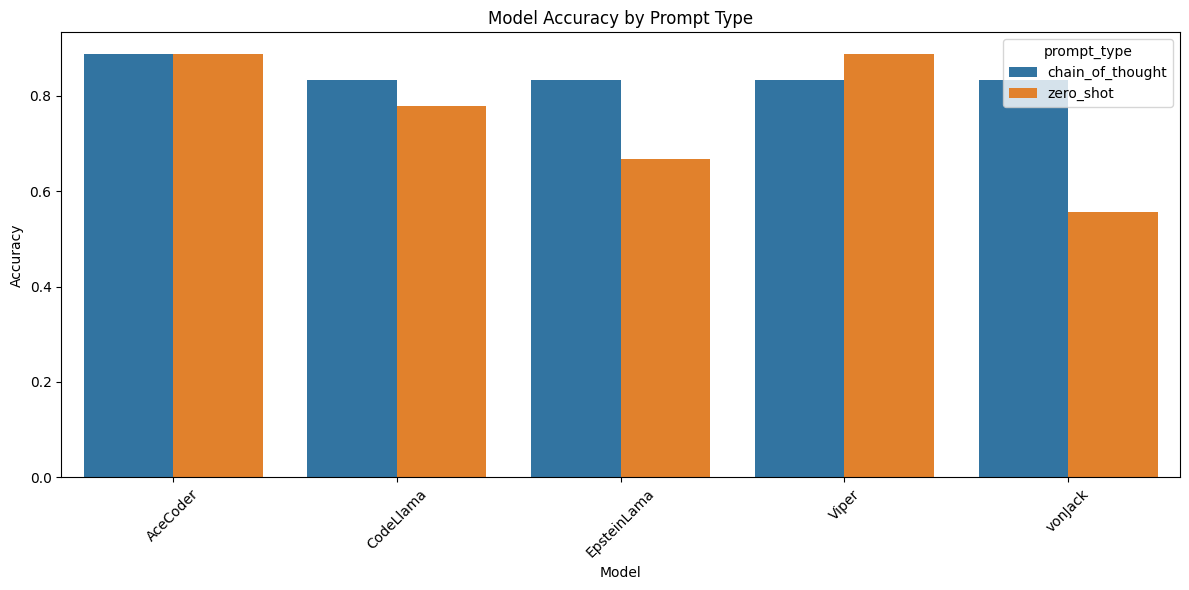

<ipython-input-9-af5bcef1b994>:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  type_accuracy = df.groupby(['model', 'test_type']).apply(


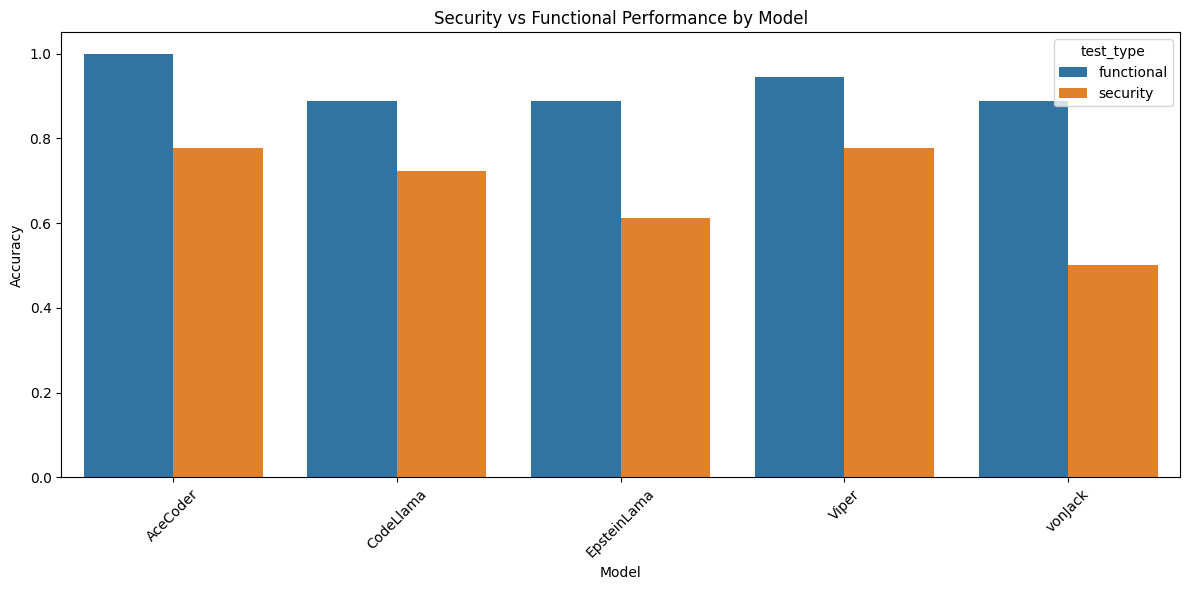

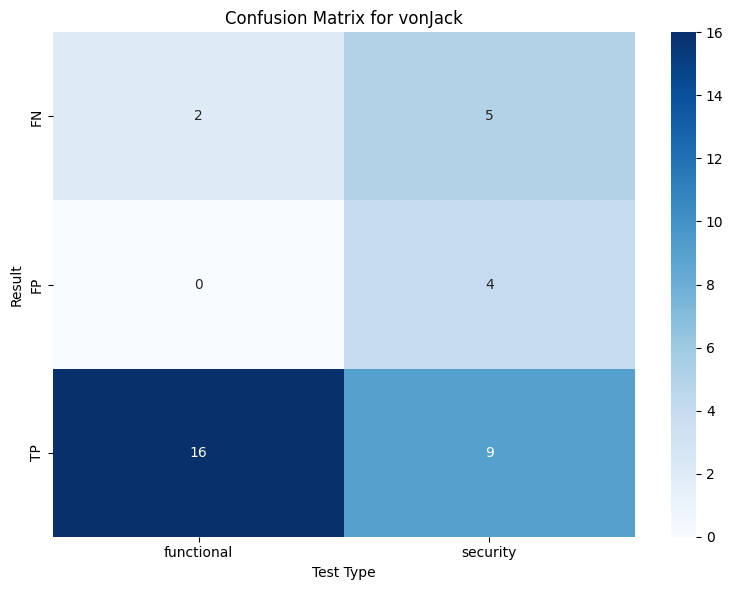

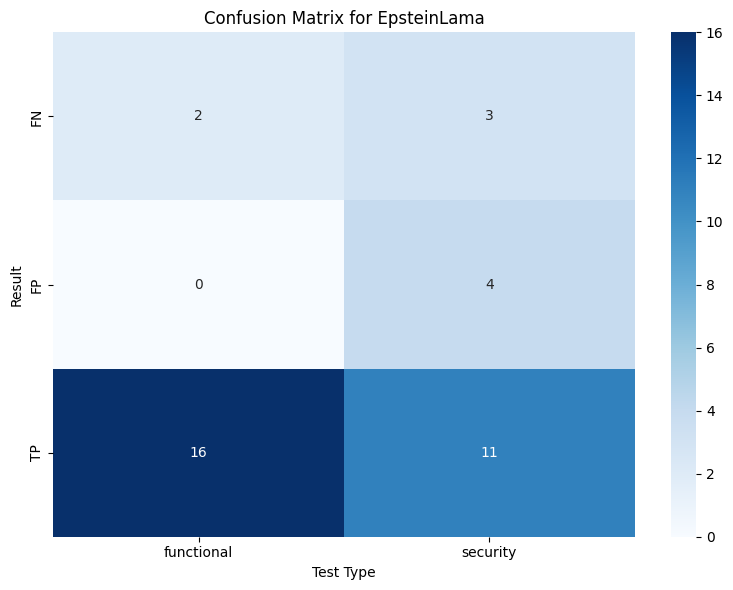

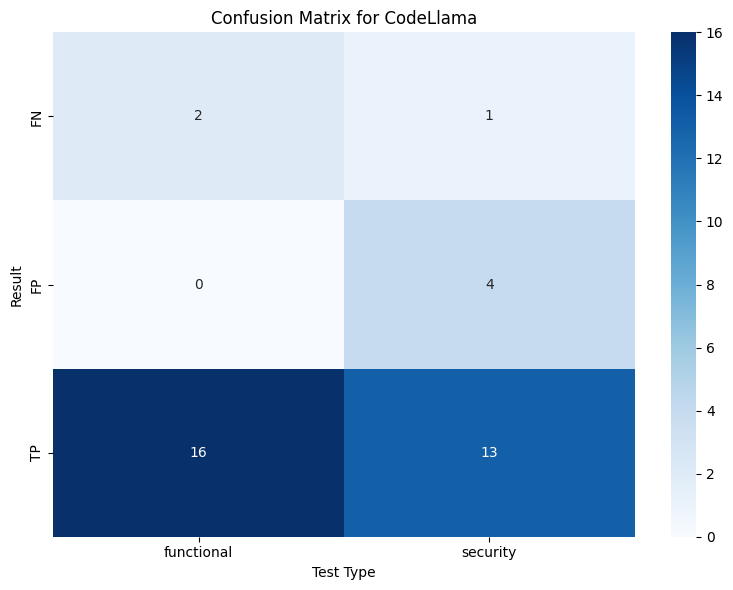

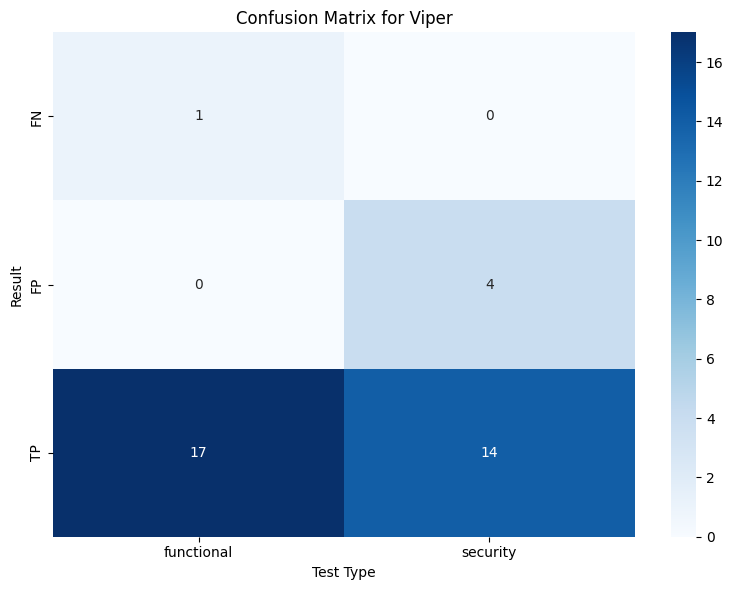

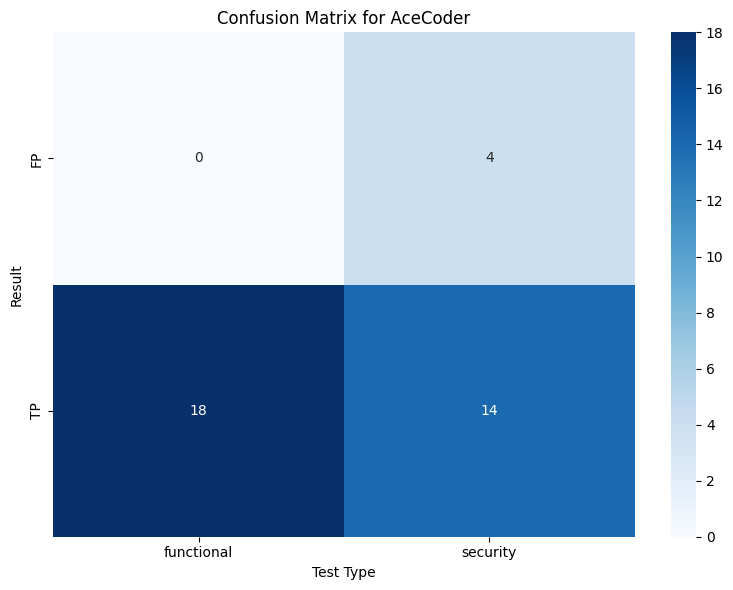

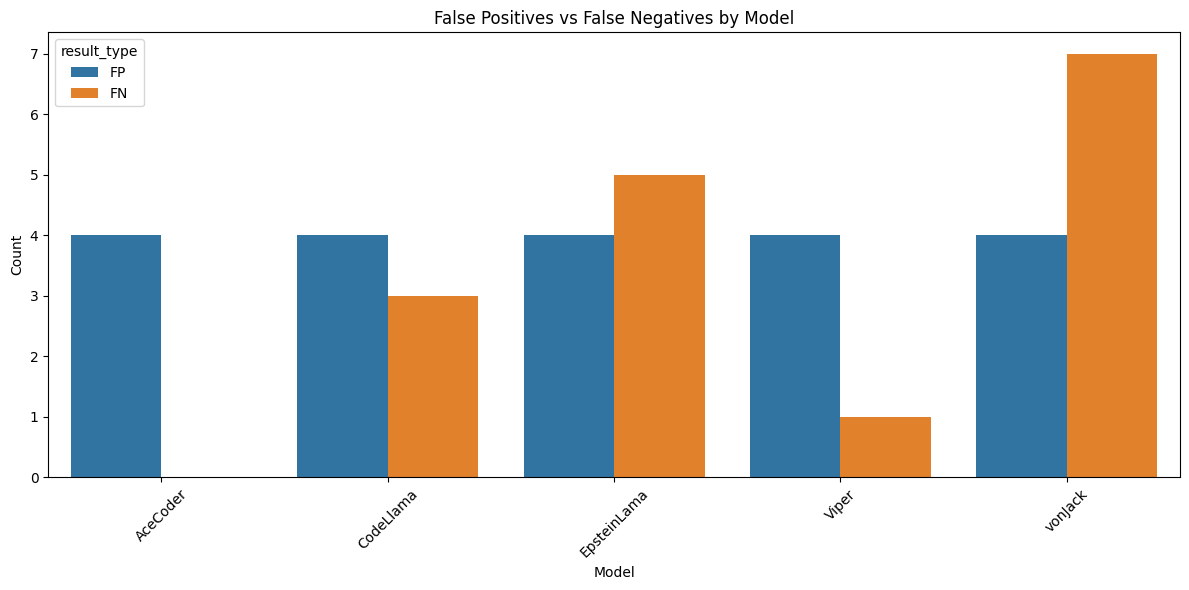

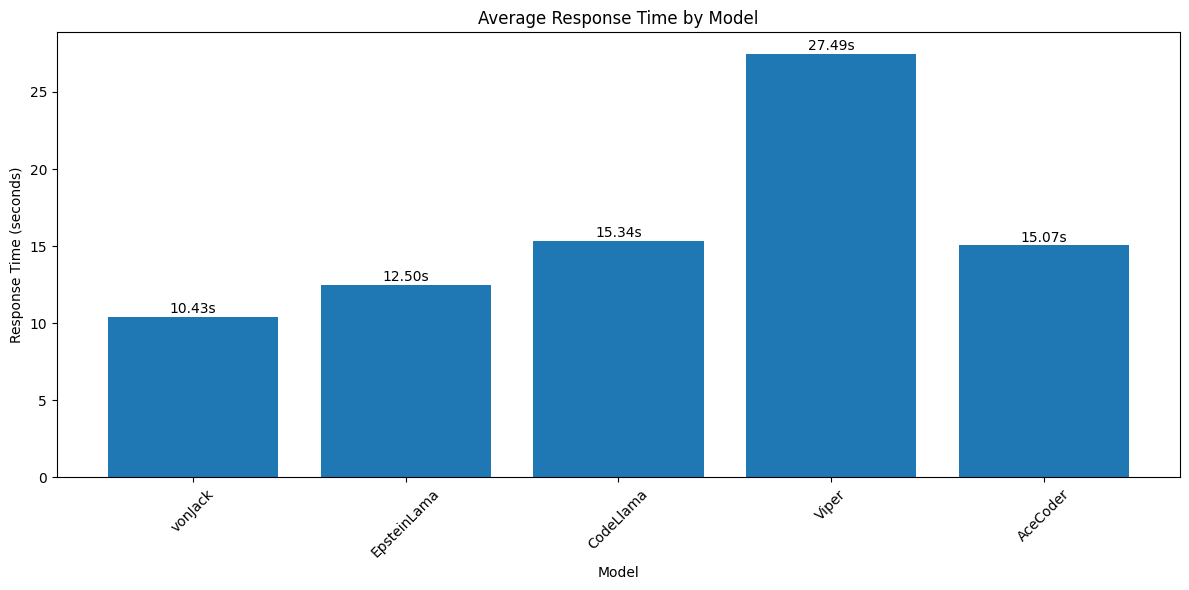

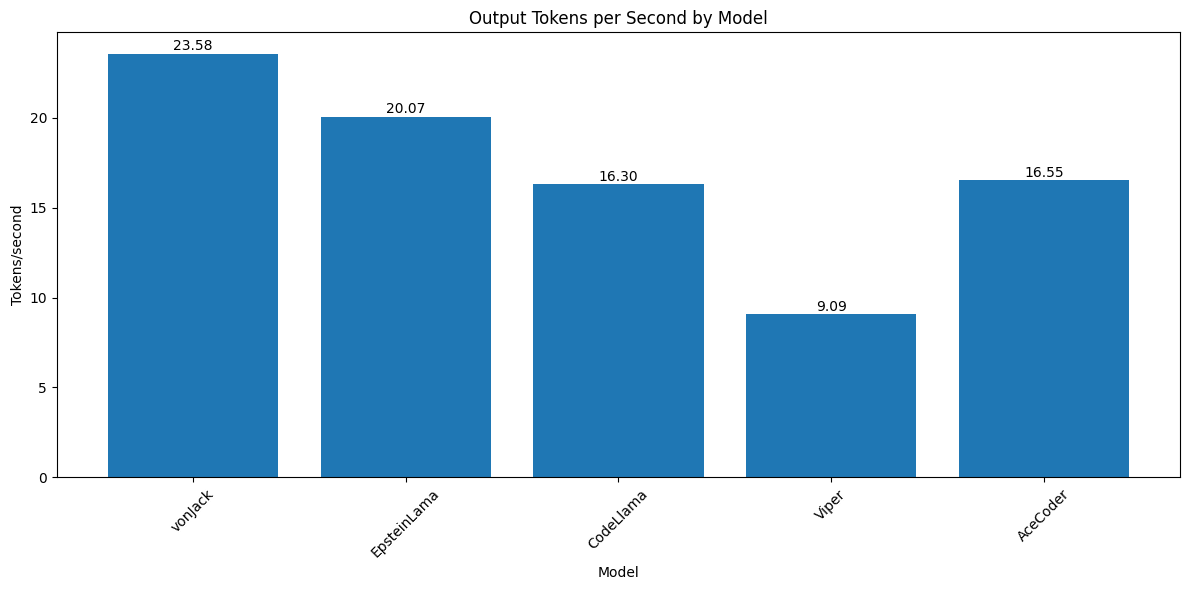

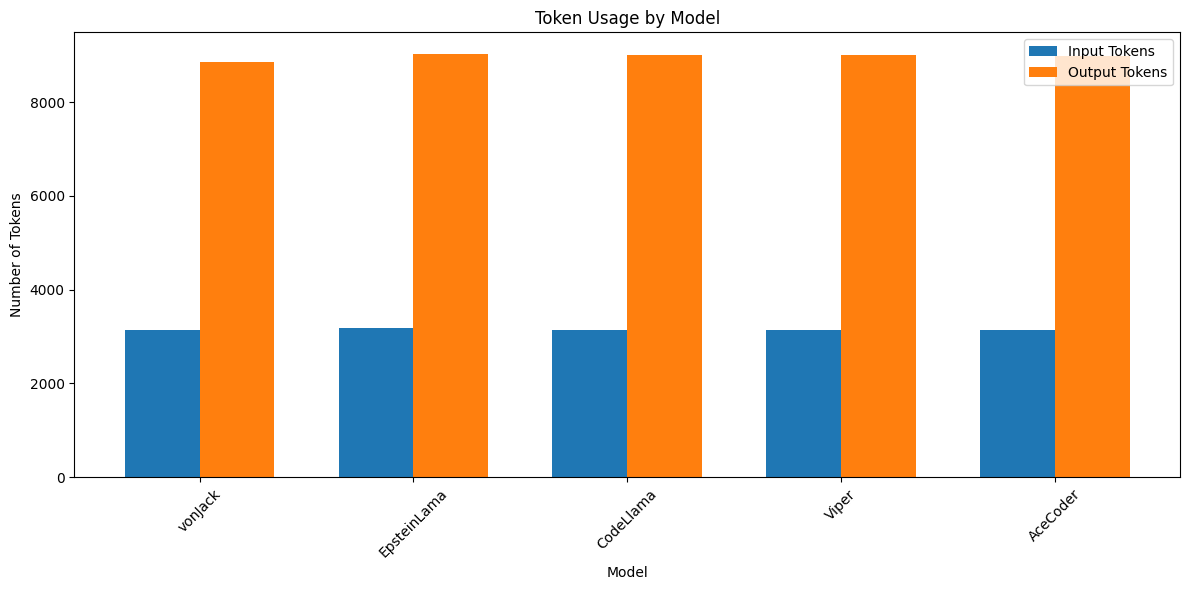

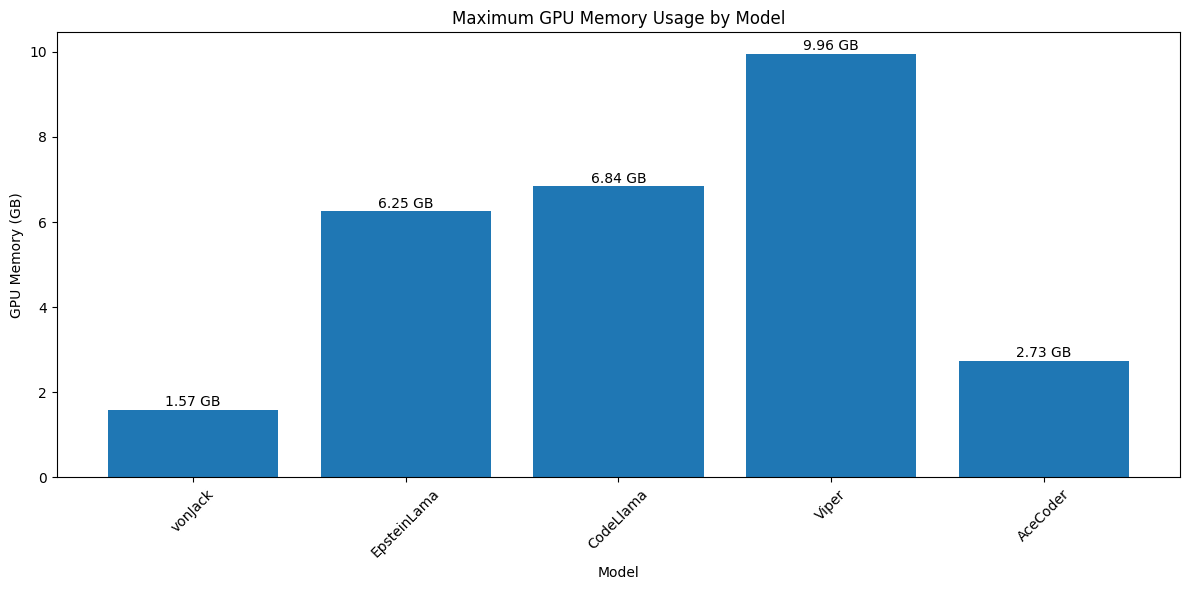

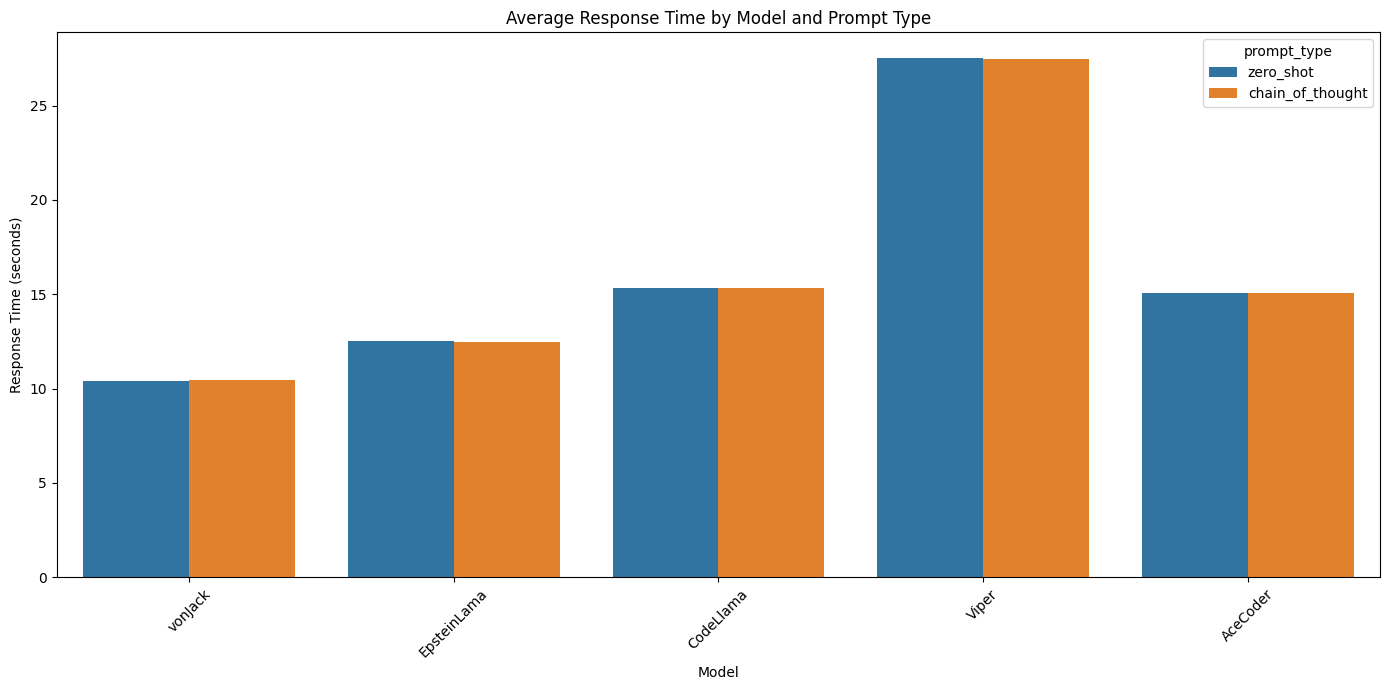


Evaluation completed at 2025-04-17 02:45:03
Final GPU Memory: 0.01GB / 0.59GB
Results saved to evaluation_results.json


In [ ]:
if __name__ == "__main__":
    # Define prmpt types to test
    prompt_types = ["zero_shot", "chain_of_thought"]

    # Run evaluation
    print(f"{COLORS['BOLD']}Starting evaluation at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}{COLORS['ENDC']}")
    results = run_evaluation(models_to_test, prompt_types)

    # Generate final report
    print_detailed_results(results)

    # Generate visualizations
    generate_visualizations(results)

    # Final memory check
    print(f"\n{COLORS['GREEN']}Evaluation completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}{COLORS['ENDC']}")

    print(f"{COLORS['YELLOW']}Final GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.memory_reserved()/1024**3:.2f}GB{COLORS['ENDC']}")

    # Save results to file
    with open('evaluation_results.json', 'w') as f:
        # Convert results to
        serializable_results = []
        for r in results:
            r_copy = r.copy()
            serializable_results.append(r_copy)
        json.dump(serializable_results, f, indent=2)

    print(f"{COLORS['GREEN']}Results saved to evaluation_results.json{COLORS['ENDC']}")